In [4]:
import pandas as pd
import numpy as np
import json
from pandas import json_normalize
import requests
from bs4 import BeautifulSoup
import json
from urllib.parse import urlencode
from getpass import getpass
from urllib.parse import urlparse, parse_qs
from requests_oauthlib import OAuth2Session
from stravalib import Client
import time
import seaborn as sns
import astropy.units as u
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
from collections import Counter
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from pandas.tseries.offsets import *
from pandas.plotting import lag_plot

%matplotlib inline

In [5]:
%config InlineBackend.figure_format = 'retina' 
pd.set_option('display.max_colwidth', 500)
# pd.reset_option('display.max_colwidth')

In [6]:
import nltk
nltk.download("stopwords", quiet=True)
from nltk.corpus import stopwords
stopwords_english = stopwords.words("english")

In [7]:
from gensim.models import Phrases

## Import CSV, Excel, JSON files

In [ ]:
pd.read_csv("c2_file.csv", names=["column 1", "column 2", "column 3", "column 4"])
pd.read_csv("c2_file.csv", index_col=0)
df2 = pd.read_csv("c2_file.csv", dtype={"b": np.float64}) # specify data types by column
pd.read_csv("c2_file.csv", usecols=["a", "b"]) # specify the columns to read

In [ ]:
pd.read_excel("c2_data.xls")
pd.read_excel("c2_data.xls", sheet_name="Sheet2")

In [ ]:
pd.read_json("c2_books.json")

In [ ]:
with open("c2_books.json", "r") as f:
    json_string = f.read()
    dictionary = json.loads(json_string)

In [ ]:
dictionary

In [ ]:
json_normalize(dictionary, 'books')

## HTML

### Parsing text

In [ ]:
page = requests.get(
    "https://web.archive.org/web/20180908144902/en.proverbia.net/shortfamousquotes.asp"
)

In [ ]:
page.text[0:100]

In [ ]:
page.status_code # says if the the page has been downloaded correctly

In [ ]:
soup = BeautifulSoup(page.text, "html.parser")

In [ ]:
quotes = soup.find_all('blockquote')

In [ ]:
quotes[0].text

In [ ]:
quote_list = []
for quote in quotes:
    string = quote.text
    quote_list.append(string)

In [ ]:
quote_list

In [ ]:
df = pd.DataFrame(quote_list, columns=['Quote'])

In [ ]:
authors = soup.find_all('p', class_='a')

In [ ]:
authors[0].text[1:-1]

In [ ]:
author_list = []
for author in authors:
    string = author.text[1:-1]
    author_list.append(string)
    
df['Author'] = author_list
df

### Parsing tables

In [ ]:
tables = pd.read_html("https://world.openfoodfacts.org/additives")
print(len(tables))

In [ ]:
print(tables[0].head())

In [ ]:
tables = pd.read_html(
    "https://en.wikipedia.org/wiki/World_record_progression_50_metres_freestyle"
)
print(len(tables))

In [ ]:
print(tables[2].head())

In [ ]:
# searching tables with a specific keyword
tables = pd.read_html(
    "https://en.wikipedia.org/wiki/World_record_progression_50_metres_freestyle",
    match="Switzerland",
)
print(len(tables))

In [ ]:
print(tables[0][10:15][["Time", "Name", "Nationality"]])

## APIs
API: contract bewtween two parties saying that if one party provides input in a pre-defined format then the other party will provide a pre-defined output
* SOAP: Simple Object Access Protocol - requests are submitted and received via a file format called XML
* REST: Representational State Transfer - requests are usually submitted using the HTTP protocol

#### Manually getting the token

In [ ]:
with open('client-credentials.json') as file:
    client_credentials = json.load(file)

In [ ]:
print('Credentials:', list(client_credentials.keys()))

In [ ]:
oauth_params = {
    'client_id': client_credentials['client_id'],
    'scope': 'read_all,profile:read_all,activity:read_all',
    'redirect_uri': 'https://localhost',
    'response_type': 'code'
}

In [ ]:
urlencode(oauth_params)

In [ ]:
# This url will return another url containing the code
print('https://www.strava.com/oauth/authorize' + '?' + urlencode(oauth_params))

In [ ]:
# After authorizing the app, user is redirected to
authorization_response = getpass(prompt='Full callback URL')

In [ ]:
# We parse the url with the coded embedded to get the code
authorization_code = parse_qs(urlparse(authorization_response).query)['code'][0]

Requests
* GET: addresses that are in the browser URL field at the top of the window; they are used to get content from the web but are not necessarily meant to send data to a web service besides short GET variables (as we saw above) - example: to list some entries
* POST: used to send/post data to a web service, data that will typically be stored by it - example: to create new entries
* PUT: used to update existing entries

In [ ]:
# Exchange Authorization Code for Access Token
r = requests.post('https://www.strava.com/oauth/token', data={
    'client_id': client_credentials['client_id'],
    'client_secret': client_credentials['client_secret'],
    'code': authorization_code,
    'grant_type': 'authorization_code'
})
r.status_code

In [ ]:
r.text

In [ ]:
r.json()

In [ ]:
def token_saver(token_obj):
    with open('token.json', 'w') as file:
        json.dump(token_obj, file, indent=4)

In [ ]:
token_saver(r.json())

In [ ]:
def get_token():
    with open('token.json', 'r') as file:
        return json.load(file)

In [ ]:
token = get_token()
token.keys()

In [ ]:
print('Expires in:', token['expires_in']) # initially: 21600 (6 hours)
print('Expires at:', token['expires_at']) # in seconds, Unix timestamp which is defined as the number of seconds since Jan 1, 1970

In [ ]:
# When the token expires, we should reach the Strava token API and ask for a new one by simply issuing a new POST request 
# with our refresh_token
r = requests.post('https://www.strava.com/oauth/token', data={
    'client_id': client_credentials['client_id'],
    'client_secret': client_credentials['client_secret'],
    'refresh_token': token['refresh_token'],
    'grant_type': 'refresh_token'
})
token_saver(r.json())
token = get_token()

In [ ]:
# Get the list of activities from the athlete
r = requests.get('https://www.strava.com/api/v3/athlete/activities', 
                 params={
                     'access_token': token['access_token'],
                     'per_page': '200',
                     'page': '2'
                 })
r.status_code

In [ ]:
# Save those activities
with open('activities.json', 'w') as file:
    json.dump(r.json(), file, indent=4)

In [ ]:
activities_df = pd.read_json(r.text)

In [ ]:
activities_df[['name','type','distance','elapsed_time','max_speed']]

#### With requests_oauthlib

In [ ]:
# Create a session for initialization
init_session = OAuth2Session(
    client_credentials['client_id'],
    redirect_uri='https://localhost',
    scope='read_all,profile:read_all,activity:read_all'
)

In [ ]:
# First, we need to authorize the app to get access the user's data
user_link, state = init_session.authorization_url('https://www.strava.com/oauth/authorize')

In [ ]:
print('Visit link:', user_link)

In [ ]:
authorization_response = getpass(prompt='Full callback URL')

In [ ]:
# Get Access Token
token = init_session.fetch_token(
    'https://www.strava.com/oauth/token',
    authorization_response=authorization_response,
    include_client_id=True,
    client_secret=client_credentials['client_secret']
)

In [ ]:
token_saver(token)

In [ ]:
# Create a session for reaching the API
api_session = OAuth2Session(
    client_credentials['client_id'],
    token=token, # pass Access Token
    
    # Automatically refresh expired token
    auto_refresh_url='https://www.strava.com/oauth/token',
    auto_refresh_kwargs={
        'client_id': client_credentials['client_id'],
        'client_secret': client_credentials['client_secret']
    },
    token_updater=token_saver # automatically saves new tokens
)

In [ ]:
r = api_session.get('https://www.strava.com/api/v3/athlete/activities')
r.status_code

In [ ]:
activities_df = pd.read_json(r.text)
activities_df[['name', 'type', 'distance', 'elapsed_time', 'max_speed']]

#### With Stravalib

In [ ]:
# Create client
client = Client()

# Get Authorization URL
user_link = client.authorization_url(
    client_id=client_credentials['client_id'],
    redirect_uri='https://localhost',
    scope=['read_all', 'profile:read_all', 'activity:read_all']
)
print('Visit link:', user_link)

In [ ]:
authorization_response = getpass(prompt='Full callback URL')

In [ ]:
authorization_code = parse_qs(urlparse(authorization_response).query)['code'][0]

In [ ]:
# Get Access Token
token = client.exchange_code_for_token(
    client_id=client_credentials['client_id'],
    client_secret=client_credentials['client_secret'],
    code=authorization_code)
token_saver(token)

In [ ]:
# Refresh token if necessary
if time.time() > token['expires_at']:
    token = client.refresh_access_token(
        client_id=client_credentials['client_id'],
        client_secret=client_credentials['client_secret'],
        refresh_token=token['refresh_token'])
    token_saver(token)

In [ ]:
# Get activities
activities = client.get_activities(limit=500)
activities

In [ ]:
for activity in activities:
    print(activity)

In [ ]:
a = list(activities)[0] # Get the first activity

print('Activity name:', a.name)
print('Distance:', a.distance)
print('Athlete name:', a.athlete.firstname)
print('Average heart rate:', a.average_heartrate)

#### Playing with Strava data

In [ ]:
list(activities)[0:2]

In [ ]:
activities_df = []
for a in list(activities):
    activities_df.append([a.name, a.upload_id, a.type, a.distance, a.moving_time, a.average_speed, 
                          a.max_speed, a.total_elevation_gain, a.start_date_local])

In [ ]:
activities_df = pd.DataFrame(activities_df, 
                             columns=['name', 'upload_id', 'type', 'distance', 'moving_time', 'average_speed', 
                                      'max_speed', 'total_elevation_gain', 'start_date_local'])

In [ ]:
activities_df.head()

In [ ]:
activities_df.info()

In [ ]:
activities_df['distance_m'] = [float(d) for d in activities_df['distance']]
activities_df['total_elevation_gain_m'] = [float(d) for d in activities_df['total_elevation_gain']]
activities_df['average_speed_ms'] = [float(d) for d in activities_df['average_speed']]

In [ ]:
activities_df['distance_km'] = round(activities_df['distance_m'] / 1000, 1)
activities_df['total_elevation_gain_km'] = round(activities_df['total_elevation_gain_m'] / 1000, 1)
activities_df['average_speed_kmh'] = round(activities_df['average_speed_ms'] * 3.6, 1)

In [ ]:
activities_df.type.value_counts()

In [ ]:
activities_df.groupby('type')[['average_speed_kmh','distance_km','moving_time','total_elevation_gain_m']].describe().T

In [ ]:
activities_df[['average_speed_kmh','distance_km','moving_time','total_elevation_gain_m']].corr()

In [ ]:
runs = activities_df.loc[activities_df['type'] == 'Run']

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (7, 5))
sns.histplot(data=runs, x='average_speed_kmh', binwidth=0.5).set_title('Average Speed (km. per h.) by Count of Runs')
plt.axvline(x=runs.average_speed_kmh.mean(), color='red')
fig.tight_layout()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (7, 5))
sns.histplot(data=runs, x='distance_km', binwidth=1).set_title('Distance (km.) by Count of Runs')
plt.axvline(x=runs.distance_km.mean(), color='red')
fig.tight_layout()

In [ ]:
sns.set(style="ticks", context="talk")
sns.regplot(x='distance_km', y = 'average_speed_kmh', data = runs).set_title("Average Speed vs Distance")
plt.show()

## Handling missing and null values

In [ ]:
df = pd.read_csv("c2_tmdb_5000_movies.csv")

In [ ]:
df.shape

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
df.isnull().head()

In [ ]:
df.notnull().head()

In [ ]:
df.isnull().sum()

#### Dropping missing values
Either drop we drop an observation or a variable (column)

In [ ]:
df2 = df.dropna() # drops row if there is at least one nan

In [ ]:
df2.isnull().sum().sum()

In [ ]:
print(df.shape)
print(df2.shape)

In [ ]:
df3 = df.dropna(how='all')
df3.shape

In [ ]:
print(df.dropna(axis=1).shape)
print(df.dropna(how="all", axis=1).shape)

In [ ]:
df.dropna(thresh=4000, axis=1, inplace=True) # thresh: Require that many non-NA values.
# columns with less than 4000 non-null values are dropped

In [ ]:
df.isnull().sum().sum()

#### Replacing missing values

In [ ]:
df.isnull().sum()

In [ ]:
df.overview.head(5)

In [ ]:
df.release_date.head(5)

In [ ]:
df.runtime.head(5)

In [ ]:
df['overview'].fillna(value='Overview not available', inplace=True)

In [ ]:
df.overview.isnull().sum()

In [ ]:
df.loc[df.release_date.isnull(), 'release_date']

In [ ]:
df.loc[4552:4554, 'release_date']

In [ ]:
df.release_date.fillna(method='ffill')[4552:4555]

In [ ]:
df.release_date.fillna(method='bfill')[4552:4555]

In [ ]:
df.release_date.fillna(method='ffill', inplace=True)

In [ ]:
df.runtime.mean()

In [ ]:
df.runtime.fillna(value=df.runtime.mean(), inplace=True)

#### Removing duplicated values

In [ ]:
df = pd.DataFrame(
    {"color": ["blue", "blue", "red", "red", "blue"], "value": [2, 1, 3, 3, 2]}
)

In [ ]:
df.duplicated()

In [ ]:
df.duplicated(keep="last")
# the last occurrence of a duplicated value is marked as False and all previous occurrences are marked as True

In [ ]:
df.duplicated(keep=False)
# mark all occurrences of a duplicated row as True

In [ ]:
df.loc[df.duplicated(),:]

In [ ]:
df.drop_duplicates()

In [ ]:
df.drop_duplicates(keep="last")

In [ ]:
df.drop_duplicates(["color"])

In [ ]:
df

#### Exercise

In [ ]:
df = pd.read_csv("http://bit.ly/chiporders", sep="\t")

In [ ]:
df.head()

In [ ]:
df.shape

In [ ]:
# 1. Find the number of duplicated rows.
df.duplicated().sum()

In [ ]:
# 2. Find the number of duplicated values in each column.
for col in df.columns:
    print(df.duplicated(col).sum())

In [ ]:
# 3. Find the number of duplicated rows with respect to the columns 'order_id', 'item_name' and 'item_price'.
df.duplicated(['order_id','item_name','item_price']).sum()

In [ ]:
# 4. Remove all occurrences of the duplicated rows with respect to the columns 'order_id', 'item_name' and 'item_price'.
df.drop_duplicates(['order_id','item_name','item_price'], keep=False).shape

## Detecting and filtering outliers

In [ ]:
# Create a random seed to make result reproducible
np.random.seed(0)

# Create 5 features with 100000 samples from Gaussian distribution each
df = pd.DataFrame(np.random.randn(100000, 5))

# Add 1000 to the last 100 values of feature 4
df.iloc[-100:, 4] = df.iloc[-100:, 4] + 1000

# Create 6th feature with 100000 samples from exponential distribution
df[5] = np.random.exponential(1, 100000)

# Change feature names
df = df.add_prefix("X")
df.head()

In [ ]:
df.describe().round(5)

In [ ]:
fig, axes = plt.subplots(
    2, 3, gridspec_kw={"height_ratios": (0.7, 0.3)}, figsize=(15, 6)
)

for (feat, plot_col) in zip(
    ["X0", "X4", "X5"], [0, 1, 2]  # pairing feature with column in plot
):
    axes[0, plot_col].hist(df[feat], bins=50)
    axes[0, plot_col].set_title("Histogram and boxplot for {}".format(feat))
    sns.despine(ax=axes[0, plot_col])
    sns.boxplot(data=df[feat], orient="h", ax=axes[1, plot_col], fliersize=2)
    axes[1, plot_col].set(yticks=[])
    sns.despine(ax=axes[1, plot_col], left=True)

for ax in axes.flatten():
    ax.set_xlabel("")

plt.show()

#### Manual outlier removal

In [ ]:
# Using a log-scale
plt.hist(df["X4"], bins=50)
plt.yscale("log")
plt.ylim(1, 100000)
plt.show()

In [ ]:
# As this group makes up only 0.1%, we set an upper bound at 200, to first identify and then remove these samples.
filter_200 = df["X4"] > 200
outliers_manual = df.loc[filter_200, "X4"]
outliers_manual.head()

In [ ]:
df_keep = df.loc[~filter_200, "X4"]
df_keep.shape

#### Using Z-scores
For normally distributed data, outlier rule: 3 times the standard deviation from the mean

z = (x - mean) / std

|z| > 3

In [ ]:
zfilterX0 = np.abs(df["X0"] - df["X0"].mean()) > (3 * df["X0"].std())
zfilterX0.head()

In [ ]:
df.loc[zfilterX0, "X0"].head()

In [ ]:
zfilter_df = np.abs(df - df.mean()) > (3 * df.std())

In [ ]:
zfilter_df.head(5)

In [ ]:
zscores_df = (df - df.mean()) / (df.std())
zfilter_df2 = np.abs(zscores_df) > 3

# Check the two zfilters are identical
print("Both approaches are equivalent:", zfilter_df.equals(zfilter_df2))

In [ ]:
print("Number of outliers detected per feature using z-scores:")
print(zfilter_df.sum(axis=0))
print("Total number of outliers detected:", zfilter_df.sum(axis=0).sum())

In [ ]:
zfilter_any = zfilter_df.any(axis=1)
zfilter_any.head()

In [ ]:
outliers = df.loc[zfilter_any, :]
outliers.shape

In [ ]:
df_wo = df.drop(outliers.index, axis=0)

#### Using interquartile range

In [ ]:
Q1 = np.percentile(df, 25, axis=0)
Q3 = np.percentile(df, 75, axis=0)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Print lower and upper bound for X0
print("Lower bound: {:.4f}, upper bound: {:.4f}".format(lower_bound[0], upper_bound[0]))

In [ ]:
boxplot_filter = (df < lower_bound) | (df > upper_bound)
print("Number of outliers detected per feature using a boxplot:")
print(boxplot_filter.sum(axis=0))
print("Total number of outliers detected:", boxplot_filter.sum(axis=0).sum())

#### Problems with outlier detection methods
* Assumption: single population. When different populations in the data, each of these groups might be generated by a different mechanism without being an outlier
* Mean and std are affected by outliers => work with robust statistics (median and median absolute deviation (MAD))
* Both z-scores and boxplots assume the data is roughly symmetrically distributed around the ‘center’ => skewness affects the number of identified outliers by both methods

#### Exercise

In [ ]:
# 1. Import the dataset as a pandas DataFrame.
df = pd.read_csv("c2_tmdb_5000_movies.csv")

In [ ]:
# 2. Find the names of all the movies whose length is at least 180min.
df.loc[df.runtime >= 180,'original_title'].head()

In [ ]:
# 3. Using multiple filtering, find the names of all the movies whose length is at least 180min, 
# or whose vote average is at least 8.0. (Hint: use the logical operator | )
df.loc[(df.runtime >= 180) | (df.vote_average >= 8), 'original_title'].head()

In [ ]:
# 4. Using multiple filtering find the names of all the movies whose length is at least 180min, 
# and whose vote average is at least 8.0. (Hint: use the logical operator & )
df.loc[(df.runtime >= 180) & (df.vote_average >= 8), 'original_title']

In [ ]:
# 5. Using multiple filtering, find the names of all the movies whose length is at least 180min, 
# and whose vote average is at least 8.0 and whose original language is not English. 
# (Hint: use the logical operator & twice )
df.loc[(df.runtime >= 180) & (df.vote_average >= 8) & (df.original_language != 'en'), 'original_title']

## Transforming the data

In [ ]:
data = {
    "class": [1, 1, 1, 2, 2],
    "score": [10, 21, 35, 11, 26],
    "result": [0, 1, 0, 1, 0],
    "performance": ["strong", "weak", "normal", "weak", "strong"],
}
df = pd.DataFrame(data)

#### Mapping

In [ ]:
df["pass or fail"] = df.result.map({0: "fail", 1: "pass"})
# It is always a good practice to store the results in a new column instead of replacing an existing column

#### Apply functions

In [ ]:
def stand(x):
    mean = df.score.mean()
    std = df.score.std()
    y = (x - mean) / std
    return y

In [ ]:
df["score standard"] = df.score.apply(stand)

In [ ]:
df_num = df.loc[:, ["class", "result", "score", "score standard"]]
df_num

In [ ]:
df_num.apply(max, axis=0)

In [ ]:
df_num.apply(max, axis=1)

In [ ]:
# applymap(): for DataFrames, it's used for applying a function to every element of a DataFrame. 
# apply(): for either rows or column.

In [ ]:
df_new = df_num.applymap(lambda x: "\$" + str(x))
df_new

#### Exercise: applying functions

In [ ]:
# Load data
cereal = pd.read_csv("c2_cereal.csv")

# Print data shape
print('Data shape: ',cereal.shape)

In [ ]:
cereal.head()

In [ ]:
# 1) Create a new column called Manufacturer which takes the entries in the column mfr and maps them to the full name:
# A = American Home Food Products;
# G = General Mills
# K = Kelloggs
# N = Nabisco
# P = Post
# Q = Quaker Oats
# R = Ralston Purina
cereal['Manufacturer'] = cereal.mfr.map({'A': 'American Home Food Products',
                                         'G': 'General Mills',
                                         'K': 'Kelloggs',
                                         'N': 'Nabisco',
                                         'P': 'Post',
                                         'Q': 'Quaker Oats',
                                         'R': 'Ralston Purina'})

In [ ]:
# 2) Calories can be converted to kilojoules using the following formula: 1 calorie = 4.184 kilojoules. 
# Find the amount of Kilojoules per serving for each cereal. Store the results in a new column.
cereal['kJ'] = cereal.calories.apply(lambda x: x * 4.184)

In [ ]:
# 3) For each numerical column, find the cereal with the maximum value per column.
def find_max(col):
    cereal_max = cereal.loc[cereal[col.name] == max(cereal[col.name]),'name']
    return list(cereal_max)[0]

In [ ]:
cereal[['calories', 'protein', 'fat', 'sodium', 'fiber',
       'carbo', 'sugars', 'potass', 'vitamins', 'shelf', 'weight', 'cups',
       'rating']].apply(find_max, axis=0)

## Concatenating

In [ ]:
# concatenate axis=0, one on the top of the other: pd.concat([df1, df2]).reset_index(drop=True)
# reset_index otherwise initial index are kept

# creation of hierarchical index: df4 = pd.concat([df1, df2], keys=["df1", "df2"])

# concatenate axis=1, one next to the other: pd.concat([df1, df3], axis=1)

# join='inner' keeps only the intersection: pd.concat([df1, df2], axis=1, join="inner")

## Merging and joining

In [ ]:
# pd.merge(gold, bronze, on=["Code", "Country"], suffixes=["_gold", "_bronze"])
# attention pour outer join: NaN is considered a float and hence integer columns with missing values are cast as float

#### Exercise: merging with different joins

In [ ]:
left = pd.DataFrame(
    {"key1": ["a", "b", "c"], "key2": ["A", "B", "C"], "lval": [0, 1, 2]}
)
right = pd.DataFrame(
    {"key1": ["a", "b", "c"], "key2": ["A", "D", "C"], "rval": [3, 4, 6]}
)

In [ ]:
left

In [ ]:
right

In [ ]:
# A.
pd.merge(left, right)

In [ ]:
# B.
pd.merge(left, right, on=['key1','key2'], how='outer')

In [ ]:
# C.
pd.merge(left, right, on=['key1','key2'], how='right')

In [ ]:
# D.
pd.merge(left, right, on='key1')

## Pivoting

In [ ]:
# pivot_table() is a generalization of the pivot() function that allows for duplicated values in the pivoted index/column pairs

# This function has an additional parameter called aggfunc, which allows us to specify a function that 
# tells pandas how to aggregate or combine the different values that map to the same entry, and return a single value. 
# The default option is the mean() function. The tuple function creates a list of the values.

# pivot_table only aggregates numerical data types in the parameter values 
# pivot() aggregates both numeric and non-numeric data types

#### Exercise: pivoting

In [ ]:
songs = pd.read_csv("c2_songs.csv")
songs.head()

In [ ]:
songs_pivot = songs.pivot(index=['Decade', 'Musician', 'Name'], columns='Genre')

In [ ]:
def set_x(value):
    return 'x'

In [ ]:
songs_pivot = songs.pivot_table(index=['Decade', 'Musician', 'Name'], columns='Genre', values='Minutes', aggfunc=set_x, fill_value=' ')

## Hierarchical indexing

In [ ]:
# df.set_index(['',''], inplace=True)

In [ ]:
songs.head()

In [ ]:
songs.set_index(['Decade','Musician']).head()

In [ ]:
songs.set_index(['Decade','Musician']).sort_index().head()

## Stacking and unstacking

In [ ]:
# The stack() function takes the innermost column label and turns it into the innermost row index. 
# The overall effect is to make the DataFrame taller.

# The unstack() function is the inverse operation: it takes the innermost row index and 
# turns it into the innermost column label. The overall effect is to make the DataFrame wider.

In [ ]:
# define the MultiIndex for the rows
row_levels = [["R0", "R1"], ["r00", "r01", "r10", "r11"]]
row_labels = [[0, 0, 1, 1], [0, 1, 2, 3]]
row_indices = pd.MultiIndex(row_levels, row_labels)

# define the MultiIndex for the columns
col_levels = [["C0", "C1"], ["c00", "c01", "c10", "c11"]]
col_labels = [[0, 0, 1, 1], [0, 1, 2, 3]]
col_indices = pd.MultiIndex(col_levels, col_labels)

# define the data
data = np.arange(16).reshape(4, 4)

# create the dataframe
df = pd.DataFrame(data, index=row_indices, columns=col_indices)

In [ ]:
df

In [ ]:
df.unstack()

In [ ]:
df.unstack(level=0)

In [ ]:
df.stack().unstack()

In [ ]:
df.stack(level=0).unstack(level=0)

In [ ]:
# df.stack(level=0).unstack().swaplevel(axis=1).dropna(axis=1)

## Grouping

In [ ]:
raw_data = {'team': ['Ten Snakes', 'Ten Snakes', 'Ten Snakes', 'Ten Snakes', 
                     'Nine Monkeys', 'Nine Monkeys', 'Nine Monkeys', 'Nine Monkeys', 
                     'Eight Eagles', 'Eight Eagles'], 
        'rank': ['1st', '1st', '2nd', '2nd', '1st', '1st', '2nd', '2nd','1st', '2nd'], 
        'name': ['James', 'Allen', 'Matthew', 'James', 'Devon', 'Sam', 'Justin', 'Sam', 'Paul', 'Ross'], 
        'score1': [16,35,55,29,2,61,68,41,94,18],
        'score2': [81,65,54,44,28,93,2,5,53,99]}
df = pd.DataFrame(raw_data, columns = ['team', 'rank', 'name', 'score1', 'score2'])

In [ ]:
grouped = df.groupby("team")
list(grouped) # lists all of the groups and the items in each group

In [ ]:
# grouped.describe()
# grouped.mean()
# grouped.size()
# grouped.count()
grouped.get_group("Ten Snakes")

In [ ]:
df2 = df.set_index(["team", "rank"])
grouped2 = df2.groupby(level=["team", "rank"])
# grouped2.size()
grouped2.get_group(("Eight Eagles", "1st"))

In [ ]:
grouped2.agg(np.sum)

In [ ]:
def f(x):
    m = x.mean(numeric_only=True)
    return (m.score1 > 50) & (m.score2 > 50)

In [ ]:
grouped.filter(f)

#### Exercise: grouping and filtering
Filter df2: a group is kept if and only if all the values of the group are greater than 50 in both score1 and score2

In [ ]:
def fil(x):
    s1 = all([i > 50 for i in x.score1])
    s2 = all([i > 50 for i in x.score2])
    return s1 & s2

In [ ]:
grouped2.filter(fil)

## Working with text data

In [ ]:
# Python’s string functions are for individual string objects, 
# while the pandas functions are for Series and DataFrames.
# str function needs to be performed on a column

# s.str[0:2] or s.str.slice(0, 2) or str.slice_replace(i, j, 'str')
# s.str.split(" ", expand=True)
# str.contains() or s.str.contains("0", na=False)
# http://pandas.pydata.org/pandas-docs/stable/text.html

#### Exercise: cleaning up the movies dataset

In [ ]:
movies = pd.read_csv("c2_tmdb_5000_movies.csv")

In [ ]:
movies.select_dtypes("object").iloc[:5,:3]

##### Genres

In [ ]:
genres = movies["genres"]

In [ ]:
genres[0]

In [ ]:
json_obj = json.loads(genres[0])  # Load json string
names = [
    x["name"] for x in json_obj
] 
names

In [ ]:
", ".join(names)

In [ ]:
genres.map(lambda s: ', '.join(x['name'] for x in json.loads(s)))

In [ ]:
def transform(s):
    s = s.str.strip("[]")
    return s

In [ ]:
genres = transform(genres)
genres[0]

In [ ]:
def transform(s):
    s = s.str.strip("[]")
    s = s.str.replace("{", "", regex=True)
    s = s.str.replace("}", "", regex=True)
    s = s.str.replace(",", "", regex=True)
    s = s.str.replace('"id":', "", regex=True)
    s = s.str.replace('"name":', "", regex=True)
    s = s.str.replace('"', "", regex=True)
    return s

In [ ]:
genres = transform(genres)
genres[0]

In [ ]:
def transform(s):
    s = s.str.strip("[]")
    s = s.str.replace("{", "", regex=True)
    s = s.str.replace("}", "", regex=True)
    s = s.str.replace(",", "", regex=True)
    s = s.str.replace('"id":', "", regex=True)
    s = s.str.replace('"name":', "", regex=True)
    s = s.str.replace('"', "", regex=True)
    s = s.str.replace("0", "", regex=True)
    s = s.str.replace("1", "", regex=True)
    s = s.str.replace("2", "", regex=True)
    s = s.str.replace("3", "", regex=True)
    s = s.str.replace("4", "", regex=True)
    s = s.str.replace("5", "", regex=True)
    s = s.str.replace("6", "", regex=True)
    s = s.str.replace("7", "", regex=True)
    s = s.str.replace("8", "", regex=True)
    s = s.str.replace("9", "", regex=True)
    s = s.str.replace("    ", ", ")
    s = s.str.replace("   ", "")
    return s

In [ ]:
genres = transform(genres)
genres[0]

In [ ]:
movies["genres"] = genres

In [ ]:
movies.loc[:, ["title", "genres"]].head(10)

##### Keywords
Transform the entries of the column keywords so that they each contain the first 3 keywords separated by a comma.

In [ ]:
keywords = movies["keywords"]

In [ ]:
keywords[0]

In [ ]:
keywords.map(lambda s: ', '.join(x['name'] for x in json.loads(s)[0:3]))

In [ ]:
keywords = transform(keywords)

In [ ]:
movies['keywords'] = keywords.str.split(',').apply(lambda x:",".join(x[:3]))

In [ ]:
keywords_df = keywords.str.split(',', expand=True)
keywords_df[0] + ', ' + keywords_df[1] + ', ' + keywords_df[2]

In [ ]:
movies.head(10)

#### Regex

s.str.contains("John|Colin")

The metacharacter . matches any character other than a new line

Square brackets []: inside the brackets, we can specify a set of characters to match.
* [a-z] - match any lowercase letter
* [A-Z] - match any uppercase letter
* [0-9] - match any digit
* [a-zA-Z0-9] - match any letter or digit

The ^ symbol inside the square brackets matches any characters NOT in the set
* [^a-z] - match any character that is not a lowercase letter
* [^A-Z] - match any character that is not a uppercase letter
* [^0-9] - match any character that is not a digit
* [^a-zA-Z0-9] - match any character that is not a letter or digit

Common sequences
* \d - match any digit
* \D - match any non-digit
* \w - match any alphanumeric character (letter or digit) or an underscore (_)
* \W - match any character that is not alphanumeric or an underscore as described above
* \s - match whitespace (spaces, tabs, newlines, etc.)
* \S - match non-whitespace

Matching at the start and end of strings
* ^ - match at the beginning of a string
* $ - searches for matches at the end of a string

Matching preceding characters
* (*) - match zero or more copies of the preceding character
* ? - match zero or 1 copy of the preceding character
* (+) - match 1 or more copies of the preceding character

* {m} - match the preceding element m times
* {m,} - match the preceding element m times or more
* {m,n} - match the preceding element between m and n times

An important thing to know is that if a character has a special meaning, we can use a backslash \ in front of it to “escape” its special meaning. For example, if we want to match periods, we cannot just use . since this will match any character, as we mentioned before. We must use \ . instead.

Groups: patterns enclosed into parentheses

In [ ]:
s2 = pd.Series(["bar", "sugar", "cartoon", "argon"])
s2.str.contains(".ar")

In [ ]:
s2.str.contains("[bc]ar")

In [ ]:
s2[s2.str.contains("^[bc]", na=False)]

In [ ]:
s2[s2.str.contains("ar$", na=False)]

In [ ]:
s3 = pd.Series(["forest", "o", "ff", "foo", "fof"])
s3.str.contains("f+o?f+")
# + - match 1 or more copies of the preceding character
# ? - match zero or 1 copy of the preceding character

In [ ]:
s4 = pd.Series(["Monday5km", "Wednesday10km", "Saturday25km"])
s4.str.extract("(\w+day)", expand=True)
# + - match 1 or more copies of the preceding character
# \w - match any alphanumeric character (letter or digit) or an underscore (_)
# only the first match in each string is extracted.

In [ ]:
sample = 'Monday5km'

# Match groups according to regex pattern
m = re.match('(\w+day)(\d+km)', # regex pattern
             sample              # string sample
            )

# Show matched groups
m.groups()

In [ ]:
s4

In [ ]:
def f(x):
    return x.groups()[0][:3]

In [ ]:
s4.str.replace("(\w+day)",
               f,           
               regex=True
              )

#### Exercise: using regular expressions in pandas
Your task is to extract all of the times that appear in the strings and store them in a new DataFrame as the one below. Note: For the purpose of the exercise we are ignoring the time of the meal and we are always labeling the first meal of the day as breakfast, then lunch and dinner.

In [ ]:
meal_plan = [
    "Monday: 9:12am – Omelet,  3:30pm– Apple slices with almond butter",
    "Tuesday: 9:35am – Banana bread, 11:00am –Sauteed veggies, 7:02pm– Taco pie",
    "Wednesday: 9:00am – Banana pancakes",
    "Thursday: 7:23pm– Slow cooker pulled pork",
    "Friday: 3:30pm – Can of tuna",
    "Saturday: 9:11am: Eggs and sweet potato hash browns, 3:22pm: Almonds",
    "Sunday: 11:00am: Meat and veggie stir fry",
]

In [ ]:
df = pd.DataFrame(meal_plan, columns=["text"])

In [ ]:
df_split = df.text.str.split(',', expand=True)

In [ ]:
h_table = pd.DataFrame()
h_table['Days'] = df_split[0].str.extract("(\w+)")
h_table['breakfast'] = df_split[0].str.extract("(\d+:\d+\w{2})")
h_table['lunch'] = df_split[1].str.extract("(\d+:\d+\w{2})")
h_table['dinner'] = df_split[2].str.extract("(\d+:\d+\w{2})")

In [ ]:
h_table.Days = h_table.Days.str.replace("(\w+day)", lambda x: x.groups()[0][:3], regex=True)

In [ ]:
h_table.set_index('Days', inplace=True)

In [ ]:
h_table = pd.DataFrame(h_table.stack(), columns=['timestamp'])

In [ ]:
h_table = h_table.timestamp.str.extract("(\d+):(\d+)(\w{2})")

In [ ]:
h_table.columns = ['Hour', 'Minutes', 'Period']

In [ ]:
h_table

In [ ]:
sol = df.text.str.extractall('(\d?\d):(\d\d) ?([ap]m)')
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
meals = ['breakfast', 'lunch', 'dinner']

In [ ]:
sol.index.set_levels([days, meals], inplace=True)
sol.index.set_names(['Day', 'Meal'], inplace=True)
sol.columns = ['Hour', 'Minutes', 'Period']

In [ ]:
sol

## Text analytics
* Corpus: a dataset of text
* Documents: sample of text
* Tokenization: process of splitting text into constituent terms
* Tokens: the constituent terms

In [7]:
PATH_DATA = 'c2_press_releases_covid19.csv'
df = pd.read_csv(PATH_DATA)

In [ ]:
df.shape

In [ ]:
df.head()
df.sample(5)

In [8]:
df.drop(labels = ['url'],    # specify which columns to drop
        axis=1,              # drops labels from the columns
        inplace=True         # apply changes to the original df
       )

In [ ]:
df.shape

In [ ]:
print('Nb of duplicated: {}'.format(df.duplicated().sum()))

In [ ]:
df.info()

In [9]:
df['pub_date'] = pd.to_datetime(df.pub_date)

In [ ]:
df.info()

In [ ]:
print(min(df.pub_date))
print(max(df.pub_date))

In [ ]:
print(df['text'][0]) # without print, date displays not formatted

#### Checking text length

In [ ]:
len(df['text'][0].split())

In [ ]:
df.text.apply(lambda x: len(x.split()))

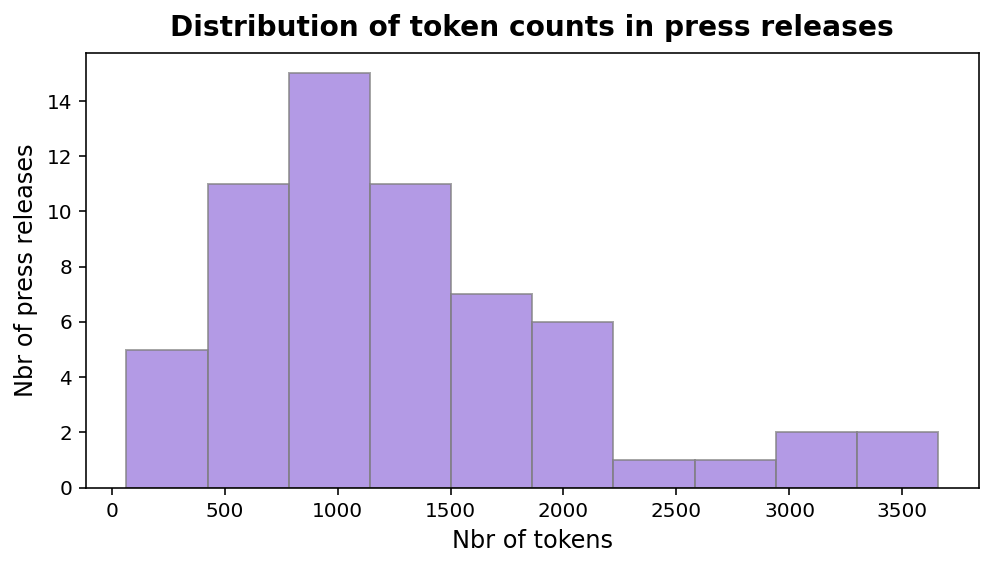

In [10]:
barplot_specs = {"color": "mediumpurple", "alpha": 0.7, "edgecolor": "grey"}
label_specs   = {"fontsize": 12}
title_specs   = {"fontsize": 14, "fontweight": "bold", "y": 1.01}

plt.figure(figsize=(8,4))

plt.hist(df['text'].apply(lambda x:len(x.split())), **barplot_specs) # ** is used to unpack dictionaries
plt.xlabel('Nbr of tokens', **label_specs)
plt.ylabel('Nbr of press releases',**label_specs)
plt.title('Distribution of token counts in press releases',**title_specs)
plt.show()

In [ ]:
df['text'].apply(lambda x: len(x.split())).describe()

In [12]:
sample = df['text'][0]

In [ ]:
print(sample)

In [ ]:
print(sample.split()[0:150]) # working only on the first 150 words

#### Word frequencies

In [13]:
# Replace punctuation marks (,.()) with whitespace
clean_sample = re.sub(r"[,.()]", # match any character that is not inside brackets
                      " ",       # replace with whitespace
                      sample     # string
                     )

# Replace single hyphens with whitespace
clean_sample = re.sub(r"\s-\s",      # match whitespaces
                      " ",           # replace with whitespace
                      clean_sample   # string
                     )

# Print clean_sample
print(clean_sample)

Bern  28 02 2020 An extraordinary meeting of the Federal Council was held today  28 February  In view of the current situation and the spread of the coronavirus  the Federal Council has categorised the situation in Switzerland as ‘special’ in terms of the Epidemics Act  Large-scale events involving more than 1000 people are to be banned  The ban comes into immediate effect and will apply at least until 15 March  The Federal Council's top priority is to protect the population  It is responding to the latest developments in the coronavirus epidemic and has categorised the situation in Switzerland as ‘special' in terms of the Epidemics Act  This enables the Federal Council  in consultation with the cantons  to order measures that are normally the responsibility of the cantons The Federal Council is banning public and private events in Switzerland at which more than 1000 people would gather  This ban on events comes into immediate effect and will apply at least until 15 March  The cantons 

In [ ]:
print(clean_sample.split()[0:150])

In [ ]:
Counter(clean_sample.split()).most_common(25)

In [14]:
# Case folding
processed_sample = clean_sample.lower()

In [ ]:
print(len(stopwords_english))
print(stopwords_english)

In [15]:
processed_sample_tokens = [tok for tok in processed_sample.split() if tok not in stopwords_english]

In [ ]:
Counter(processed_sample_tokens).most_common(25)

In [16]:
# Define preprocess_text function

def preprocess_text(text):
    
    '''
    This function preprocesses raw samples of text:
    - Converts to lowercase
    - Replaces common punctuation marks with whitespace
    - Removes stop words
    - Splits text on whitespace
    
    INPUT: 
    - text: "raw" text (string)
    
    OUTPUT:
    - processed_sample_tokens: list of tokens (list of strings)
    '''
    
    # Convert to lowercase
    clean_text = text.lower()
    
    # Replace common punctuation marks with whitespace
    clean_text = re.sub(r"[,.()]"," ", clean_text)
    
    # Replace single hyphens with whitespace
    clean_text = re.sub(r"\s-\s"," ", clean_text)
    
    # Remove stop words and split on whitespace
    processed_sample_tokens = [tok for tok in clean_text.split() if tok not in stopwords_english]
    
    return processed_sample_tokens

In [17]:
sample =  df.iloc[random.randint(0,len(df)-1),2] # selecting a random sample

In [ ]:
print(preprocess_text(sample)[0:150])

In [18]:
# applying to the corpus
preprocessed_press_releases = [preprocess_text(doc) for doc in df['text']]

# 2nd alternative (using the apply method)
df['clean_text'] = df['text'].apply(lambda x: preprocess_text(x))

In [ ]:
df.sample()

#### Collocations

In [20]:
# Create an instance of the Phrases model
n_gram_model = Phrases(preprocessed_press_releases,       # Expected input format: list of tokenized texts
                       min_count=5,                       # Keeps only collocations with at least min_counts 
                       delimiter=b'_')                    # Glue character used to join collocation tokens

In [21]:
preprocessed_press_releases_collocations = [n_gram_model[doc] for doc in preprocessed_press_releases]

In [22]:
df['clean_text'] = preprocessed_press_releases_collocations

In [23]:
df

,title,pub_date,text,clean_text
0,Coronavirus: Federal Council bans large-scale events,2020-02-28,"Bern, 28.02.2020 - An extraordinary meeting of the Federal Council was held today, 28 February. In view of the current situation and the spread of the coronavirus, the Federal Council has categorised the situation in Switzerland as ‘special’ in terms of the Epidemics Act. Large-scale events involving more than 1000 people are to be banned. The ban comes into immediate effect and will apply at least until 15 March. The Federal Council's top priority is to protect the population. It is respond...","[bern, 28, 02, 2020, extraordinary, meeting, federal_council, held, today, 28, february, view, current, situation, spread_coronavirus, federal_council, categorised, situation, switzerland, ‘special’, terms_epidemics, act, large-scale_events, involving, 1000_people, banned, ban, comes, immediate, effect, apply, least, 15, march, federal_council's, top_priority, protect_population, responding, latest, developments, coronavirus, epidemic, categorised, situation, switzerland, ‘special', terms_ep..."
1,Coronavirus: Federal Council declares ‘extraordinary situation’ and introduces more stringent measures,2020-03-16,"Bern, 16.03.2020 - At an extraordinary meeting today, 16 March 2020, the Federal Council took the decision to introduce more stringent measures to protect the public. It has declared that an ‘extraordinary situation’ now exists in Switzerland in terms of the Epidemics Act. All shops, restaurants, bars and entertainment and leisure facilities will remain closed until 19 April. Not affected by the new ruling are food stores and healthcare institutions. As of midnight, it is also introducing ch...","[bern, 16, 03, 2020, extraordinary, meeting, today, 16, march_2020, federal_council, took, decision, introduce, stringent, measures, protect, public, declared, ‘extraordinary, situation’, exists, switzerland, terms_epidemics, act, shops, restaurants_bars, entertainment_leisure, facilities, remain_closed, 19_april, affected, new, ruling, food, stores, healthcare, institutions, midnight, also, introducing, checks, borders, germany_austria, france, federal_council, also, authorised, deployment,..."
2,Coronavirus: Federal Council bans gatherings of more than five people,2020-03-20,"Bern, 20.03.2020 - The Federal Council is stepping up measures to prevent hospitals from being overwhelmed with serious cases of coronavirus disease. At its meeting on 20 March, it decided to ban gatherings of more than five people. Persons who do not comply with this may be fined. Employers in the construction sector and in industry will also be required to comply with the federal recommendations on hygiene and social distancing. Companies that do not comply may be closed down. With these m...","[bern, 20, 03, 2020, federal_council, stepping, measures, prevent, hospitals, overwhelmed, serious, cases, coronavirus, disease, meeting, 20, march, decided, ban_gatherings, five, people, persons, comply, may, fined, employers, construction, sector, industry, also, required, comply, federal, recommendations, hygiene_social, distancing, companies, comply, may, closed, measures, federal_council, aiming, avoid, need, take, even, further-reaching, action, additional, move, federal_council, makin..."
3,Coronavirus: Switzerland extends border controls to all Schengen States,2020-03-25,"Bern, 25.03.2020 - At its meeting on 25 March, the Federal Council was informed by the FDJP that entry restrictions have been extended to all Schengen States. This measure will increase the protection given to the population against the coronavirus. Last week, the Federal Council took the decision to impose restrictions on entry by land and by air from Italy, France, Germany, Austria and Spain, and from all non-Schengen States. Since midnight, these stricter entry requirements have also appl...","[bern, 25, 03, 2020_meeting, 25_march, federal_council, informed, fdjp, entry_restrictions, extended, s

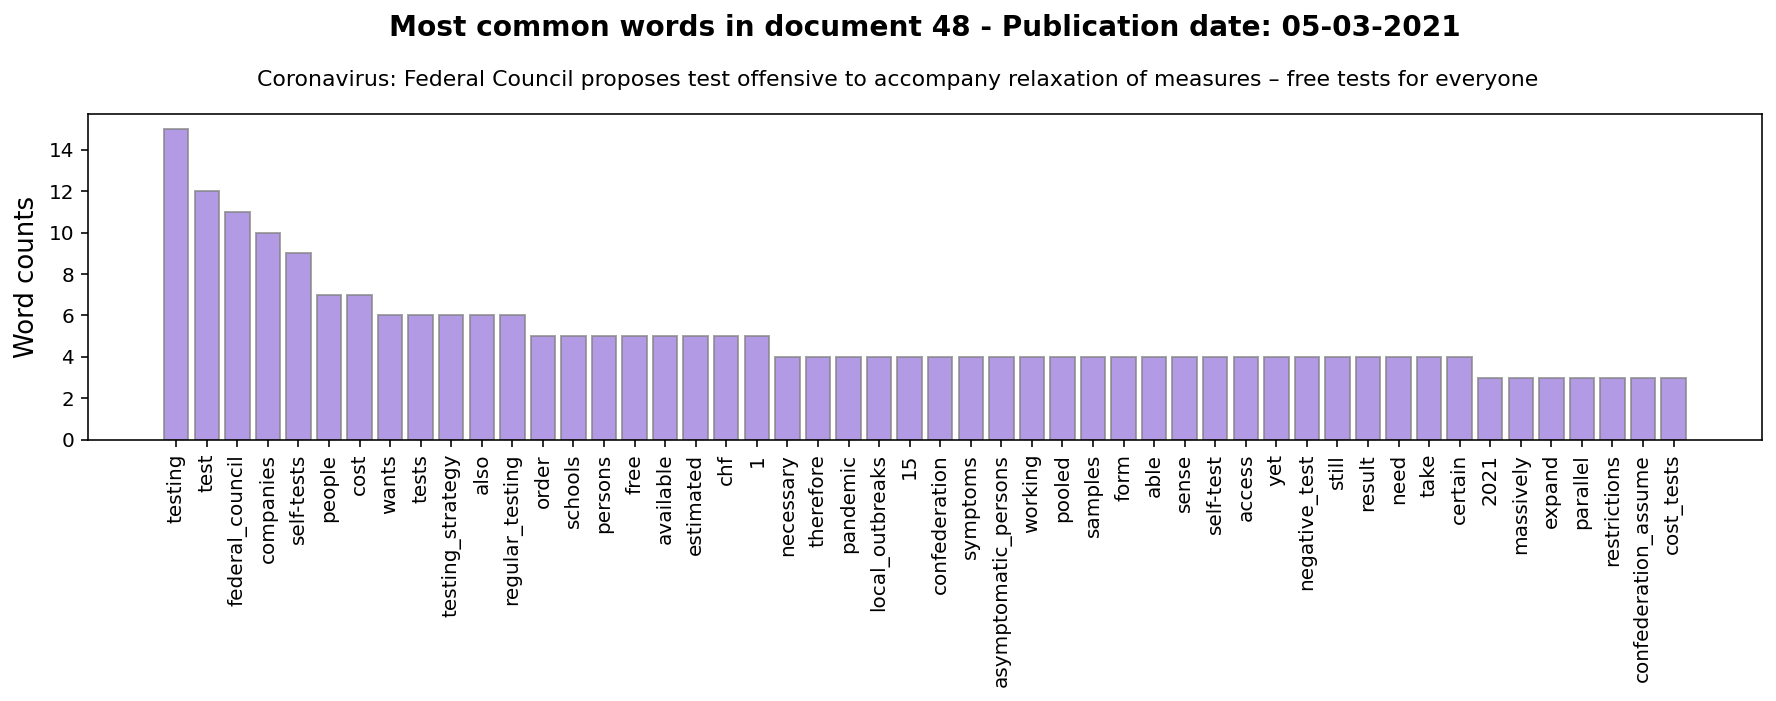

In [28]:
# Generates a random integer between 0 and len(df)
idx = random.randint(0,len(df))

# Find top-50 most common words
w = Counter(preprocessed_press_releases_collocations[idx]).most_common(50)

# Plots top words

# Barplot and font specifications
barplot_specs   = {"color": "mediumpurple", "alpha": 0.7, "edgecolor": "grey"}
title_specs     = {"fontsize": 14, "fontweight": "bold", "y": 1.2}
suptitle_specs  = {"fontsize": 11}
label_specs     = {"fontsize": 13}

plt.figure(figsize=(15,3))
plt.bar(*zip(*w), **barplot_specs)
plt.title('Most common words in document {} - Publication date: {}'.format(idx,df.iloc[idx,1].strftime("%d-%m-%Y")), **title_specs)
plt.suptitle(df.iloc[idx,0],**suptitle_specs)
plt.ylabel('Word counts', **label_specs)
plt.xticks(rotation=90)
plt.show()

#### Tf-idf weighting model
tf-idf favors words that are frequent in few press releases.

Tf-idf weighting allows focusing less on widespread words across all documents in a dataset and more on words that occur in a small fraction of the corpus.

In [36]:
tfidf = TfidfVectorizer()
# the tf-idf model expects non-tokenized text

In [37]:
# Join lists of tokens into single strings (for each press release)
X = [" ".join([w for w in doc]) for doc in preprocessed_press_releases_collocations]

In [39]:
tfidf.fit(X);

First, the TfidfVectorizer model tokenizes texts and builds the vocabulary. The vocabulary is the list of unique words in our corpus.

In [40]:
# Show vocabulary
vocabulary = tfidf.get_feature_names_out()

# Print vocabulary length
print('Vocabulary length: {}\n'.format(len(vocabulary)))

# Show a few words from vocabulary
print('Show a few words from vocabulary:')
print(vocabulary[0:500:10])

Vocabulary length: 3947

Show a few words from vocabulary:
['000' '07' '11' '128' '16' '19_april' '1_july' '2021' '23' '27_may'
 '30_people' '480' '5_million' '72' '85' 'able' 'accept' 'accompanying'
 'act' 'acute' 'additional' 'adjustment' 'adolescents' 'advantages'
 'affects' 'age_16' 'ahead' 'airline' 'allfollowing' 'allowedfrom'
 'always' 'amounting' 'announced' 'anyone' 'appeared' 'appointment'
 'april_2020' 'armed' 'article' 'assessments' 'assume_cost'
 'asymptomatic_persons' 'attention' 'austrian' 'automatically'
 'aviation_industry' 'back' 'banned' 'basically' 'beds']


In [42]:
# Get tf-idf representation of text data. To transform each sample of text in our corpus into its tf-idf representation
X_tfidf = tfidf.transform(X)
print(X_tfidf.shape)

(61, 3947)


In [43]:
df_tfidf = pd.DataFrame(X_tfidf.toarray(),
                        columns=vocabulary)
df_tfidf.head()

,000,000_people,01,02,03,04,04_2020,05,05_2020,06,...,young_people,younger,youth,zealand,zero,zones,zoos,zoos_botanical,zoosin,zurich
0,0.000000,0.0,0.0,0.054617,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.000000,0.014843,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.032799,0.0,0.0,0.000000,0.016399,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.000000,0.035813,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.123561,0.0,0.0,0.000000,0.020593,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.064655,0.0,0.0,0.0,0.0,0.0


In [44]:
N = 50
print('Printing top words according to tf-idf for document {}.'.format(idx))

Printing top words according to tf-idf for document 48.


In [46]:
# Sort indexes according to tf-idf scores for document idx
index_sorted = np.argsort(df_tfidf.iloc[idx,:])[::-1]  # descending order

# Print sorted indexes according to tf-idf
index_sorted.values

array([3579, 3194, 3588, ..., 2581, 2580,    0])

In [47]:
# Sort words in vocabulary according to tf-idf
features_sorted = np.array(vocabulary)[index_sorted][0:N]

# Print top words according to tf-idf scores
print(features_sorted)

['test' 'self' 'tests' 'testing' 'companies' 'regular_testing' 'estimated'
 'cost' 'testing_strategy' 'sense' 'samples' 'wants' 'pooled'
 'asymptomatic_persons' 'local_outbreaks' 'negative_test' 'frequently'
 'massively' 'expanding' 'persons' 'symptoms' 'schools' 'free' 'detection'
 'form' 'yet' 'parallel' 'reliable' 'available' 'federal_council'
 'working' 'confederation_assume' 'expand' 'prevention' 'cost_tests'
 'people' 'chf' 'need' 'access' 'result' 'everyone' '15' 'immediately'
 'order' 'economic_life' 'billionthe' 'irresponsible' 'snapshot' 'sample'
 'everyonesuccess']


In [48]:
# Sort tf-idf scores (descending order)
tfidf_weights_sorted = df_tfidf.iloc[idx,:][index_sorted][0:N]
print(tfidf_weights_sorted)

test                    0.301162
self                    0.299038
tests                   0.255906
testing                 0.243577
companies               0.176705
regular_testing         0.154796
estimated               0.138916
cost                    0.136359
testing_strategy        0.131639
sense                   0.122319
samples                 0.122319
wants                   0.116880
pooled                  0.111133
asymptomatic_persons    0.111133
local_outbreaks         0.103197
negative_test           0.097041
frequently              0.091739
massively               0.091739
expanding               0.091739
persons                 0.090231
symptoms                0.087759
schools                 0.085797
free                    0.085797
detection               0.083350
form                    0.077920
yet                     0.077920
parallel                0.077398
reliable                0.077398
available               0.077131
federal_council         0.075863
working   

In [50]:
idx = random.randint(0,len(df))

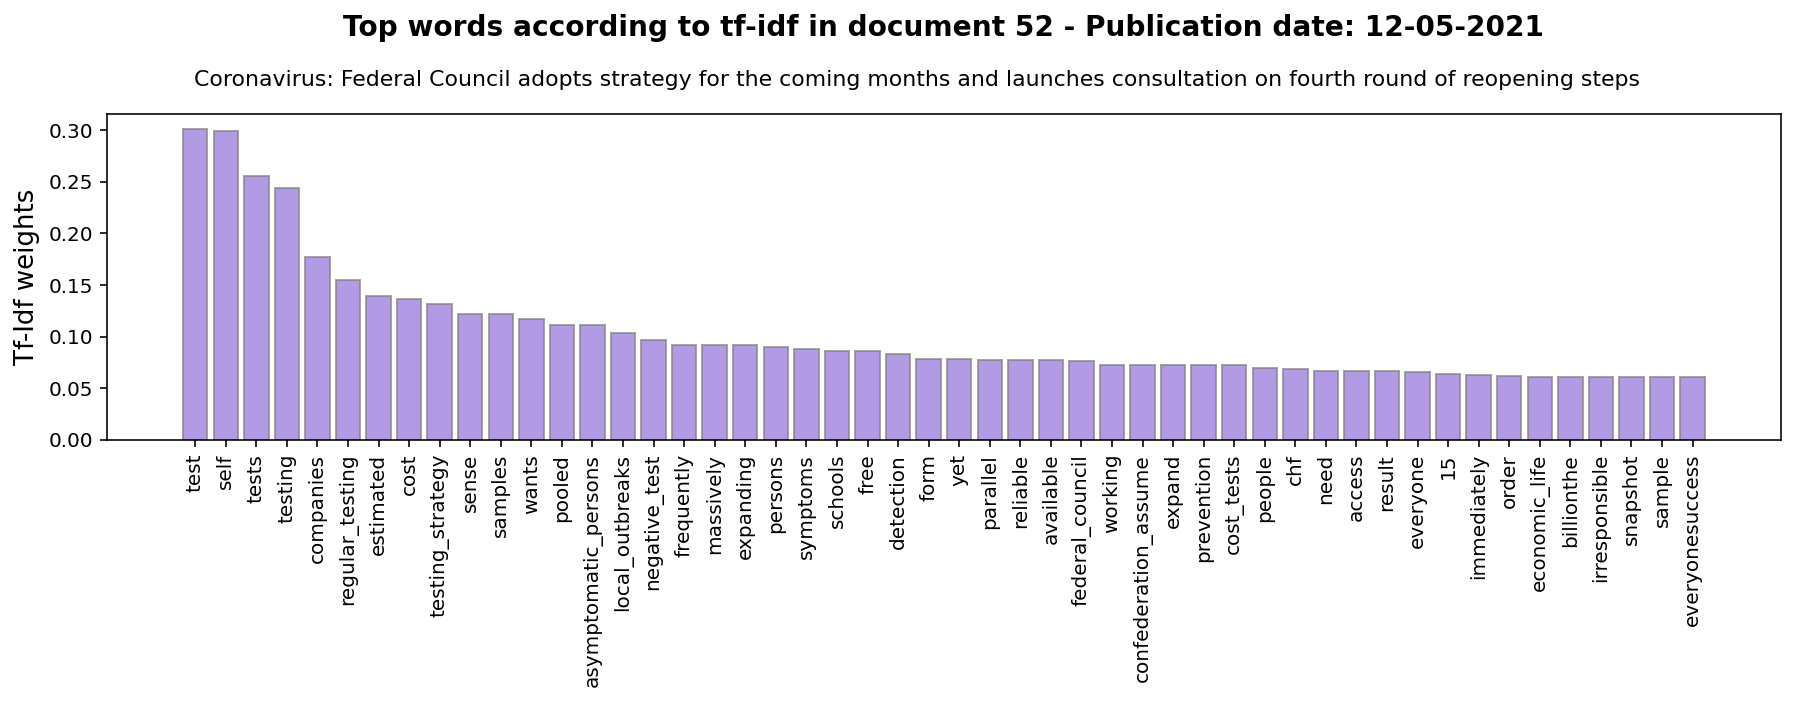

In [51]:
# Plots top words according to tf-idf scores

# Barplot and font specifications
barplot_specs   = {"color": "mediumpurple", "alpha": 0.7, "edgecolor": "grey"}
title_specs     = {"fontsize": 14, "fontweight": "bold", "y": 1.2}
suptitle_specs  = {"fontsize": 11}
label_specs     = {"fontsize": 13}

plt.figure(figsize=(15,3))

plt.bar(x = features_sorted,
        height=tfidf_weights_sorted,
        **barplot_specs)

plt.title('Top words according to tf-idf in document {} - Publication date: {}'.format(idx,df.iloc[idx,1].strftime("%d-%m-%Y")), **title_specs)
plt.suptitle(df.iloc[idx,0],**suptitle_specs)
plt.ylabel('Tf-Idf weights', **label_specs)
plt.xticks(rotation=90)
plt.show()

## Time series data

In [55]:
print(pd.to_datetime("13th of February, 2009"))
print(pd.to_datetime("02-13-2009"))
print(pd.to_datetime("Feb 13, 2009"))
print(pd.to_datetime("Feb 13, 2009 14:20:00"))
print(pd.to_datetime("13:00"))
print(pd.to_datetime("now"))
print(pd.to_datetime("Feb 13, 2009 14:20:00").day_name())

2009-02-13 00:00:00
2009-02-13 00:00:00
2009-02-13 00:00:00
2009-02-13 14:20:00
2022-05-07 13:00:00
2022-05-07 08:23:19.920117
Friday


In [58]:
dates = pd.to_datetime(
    [pd.Timestamp(2015, 8, 5), pd.Timestamp(2015, 8, 6), pd.Timestamp(2015, 8, 7)]
)
# TimeIndex
print(dates.day)
print(dates.month)

Int64Index([5, 6, 7], dtype='int64')
Int64Index([8, 8, 8], dtype='int64')


In [57]:
# TimeDelta
date1 = pd.Timestamp("2018-03-03")
date2 = pd.Timestamp("1984-03-03")
print(date1 - date2)
print(date1 + pd.Timedelta(days=54, hours=3))

12418 days 00:00:00
2018-04-26 03:00:00


In [59]:
# TimeDeltaIndex
dates - dates[0]

TimedeltaIndex(['0 days', '1 days', '2 days'], dtype='timedelta64[ns]', freq=None)

In [60]:
# Period object which encodes a fixed frequency interval
# Period object: allow us to specify a duration based on a frequency such as daily, weekly or annually
jan2015 = pd.Period("2015-01")
print(jan2015)
print(jan2015.start_time)
print(jan2015.end_time)
print(pd.Period("2015-01", freq="D"))

2015-01
2015-01-01 00:00:00
2015-01-31 23:59:59.999999999
2015-01-01


In [63]:
period = pd.Period("2015-01", freq="H")
print(period.asfreq("D"))
print(period.to_timestamp())
print(pd.Timestamp("2015-01-01 00:00:00").to_period("M"))
print(dates.to_period("D"))

2015-01-01
2015-01-01 00:00:00
2015-01
PeriodIndex(['2015-08-05', '2015-08-06', '2015-08-07'], dtype='period[D]')


In [70]:
dates.to_period("D")[0].end_time

Timestamp('2015-08-05 23:59:59.999999999')

In [74]:
# pd.Series second position are the indexes
ts1 = pd.Series(np.arange(3), dates)
ts2 = pd.Series(np.arange(3), dates.to_period("D"))
ts3 = pd.Series(np.arange(3), dates - dates[0])
print(ts1)
print(ts2)
print(ts3)

2015-08-05    0
2015-08-06    1
2015-08-07    2
dtype: int64
2015-08-05    0
2015-08-06    1
2015-08-07    2
Freq: D, dtype: int64
0 days    0
1 days    1
2 days    2
dtype: int64


In [75]:
print(ts1.index)
print(ts2.index)
print(ts3.index)

DatetimeIndex(['2015-08-05', '2015-08-06', '2015-08-07'], dtype='datetime64[ns]', freq=None)
PeriodIndex(['2015-08-05', '2015-08-06', '2015-08-07'], dtype='period[D]')
TimedeltaIndex(['0 days', '1 days', '2 days'], dtype='timedelta64[ns]', freq=None)


In [76]:
print(ts1["2015.08.05"])
print(ts1["august 5, 2015"])
print(ts1[1:3])
print(ts1["2015-08-06 ":"2015-08-07 "])
print(ts1["2015"])

0
0
2015-08-06    1
2015-08-07    2
dtype: int64
2015-08-06    1
2015-08-07    2
dtype: int64
2015-08-05    0
2015-08-06    1
2015-08-07    2
dtype: int64


In [78]:
print(pd.date_range("2018-01-01", "2018-01-05"))
print(pd.date_range("2018-01-01", periods=5))
print(pd.date_range("01-01-2018", periods=5, freq="H"))

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05'],
              dtype='datetime64[ns]', freq='D')
DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05'],
              dtype='datetime64[ns]', freq='D')
DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 01:00:00',
               '2018-01-01 02:00:00', '2018-01-01 03:00:00',
               '2018-01-01 04:00:00'],
              dtype='datetime64[ns]', freq='H')


In [79]:
pd.timedelta_range(0, periods=5, freq="H")

TimedeltaIndex(['0 days 00:00:00', '0 days 01:00:00', '0 days 02:00:00',
                '0 days 03:00:00', '0 days 04:00:00'],
               dtype='timedelta64[ns]', freq='H')

In [80]:
pd.period_range("2018-01", periods=3, freq="M")

PeriodIndex(['2018-01', '2018-02', '2018-03'], dtype='period[M]')

In [82]:
# DateOffset: regular frequency increment (BDay, Week, MonthEnd, YearEnd)
pd.Timestamp("2010.01.01") + pd.DateOffset(days=1)

Timestamp('2010-01-02 00:00:00')

In [84]:
pd.date_range("2010-07-07", periods=5, freq=BDay())

DatetimeIndex(['2010-07-07', '2010-07-08', '2010-07-09', '2010-07-12',
               '2010-07-13'],
              dtype='datetime64[ns]', freq='B')

In [85]:
# all dates corresponding to the chosen day of the week
pd.date_range("2010-07-07", periods=10, freq="W-FRI")

DatetimeIndex(['2010-07-09', '2010-07-16', '2010-07-23', '2010-07-30',
               '2010-08-06', '2010-08-13', '2010-08-20', '2010-08-27',
               '2010-09-03', '2010-09-10'],
              dtype='datetime64[ns]', freq='W-FRI')

#### Shifting and computing first differences

In [87]:
data = pd.read_csv("c2_financial_data.csv", index_col="Date")
data.index = pd.to_datetime(data.index, format="%d.%m.%y")  # Convert the index

In [89]:
data.shape

(9137, 6)

In [90]:
prices = data.Close

In [91]:
prices

Date
1984-06-01      8.00
1984-06-04      8.46
1984-06-05      8.38
1984-06-06      8.54
1984-06-07      8.54
               ...  
2020-08-24    100.06
2020-08-25    100.50
2020-08-26     99.09
2020-08-27    102.35
2020-08-28    102.77
Name: Close, Length: 9137, dtype: float64

In [93]:
prices["2012-01-01":"2012-01-10"]

Date
2012-01-03    34.98
2012-01-04    34.95
2012-01-05    35.68
2012-01-06    35.36
2012-01-09    35.30
2012-01-10    36.05
Name: Close, dtype: float64

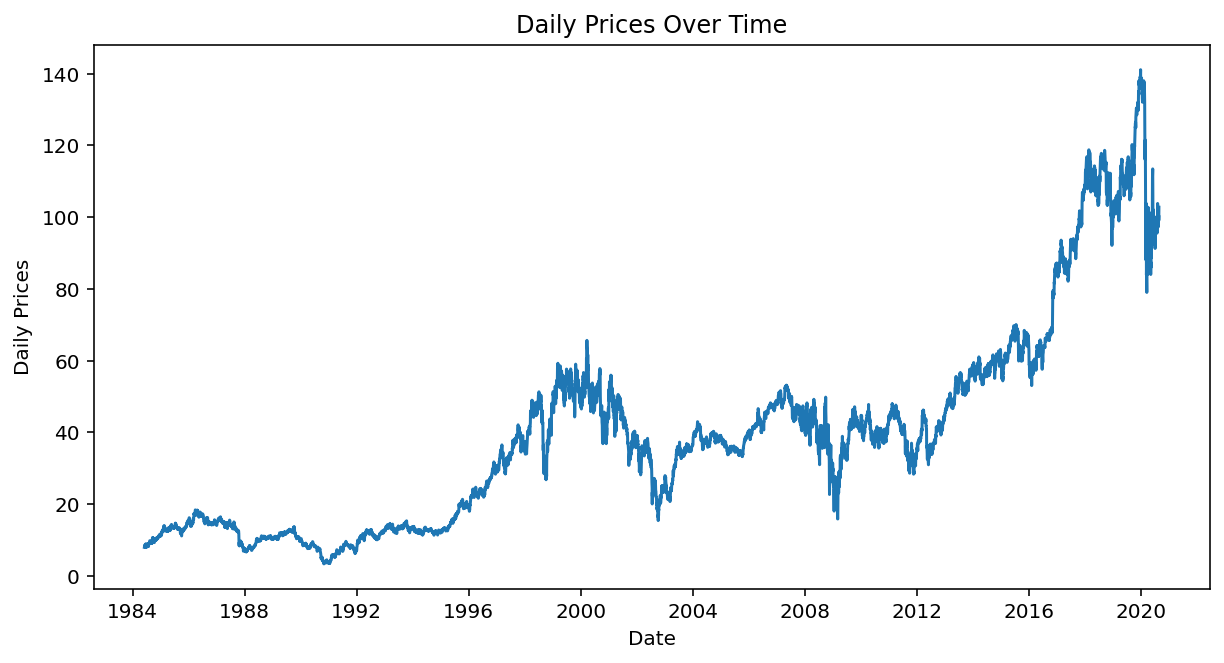

In [94]:
fig = plt.subplots(figsize=(10, 5))

plt.plot(prices)
plt.title("Daily Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Daily Prices")
plt.show()

In [98]:
Pt = prices["2019-12-15":"2019-12-30"]
Pt.shift(periods=1) # sifhts the values to the next day

Date
2019-12-16       NaN
2019-12-17    137.34
2019-12-18    138.18
2019-12-19    138.04
2019-12-20    137.35
2019-12-23    137.24
2019-12-24    137.20
2019-12-26    137.58
2019-12-27    139.04
2019-12-30    139.14
Name: Close, dtype: float64

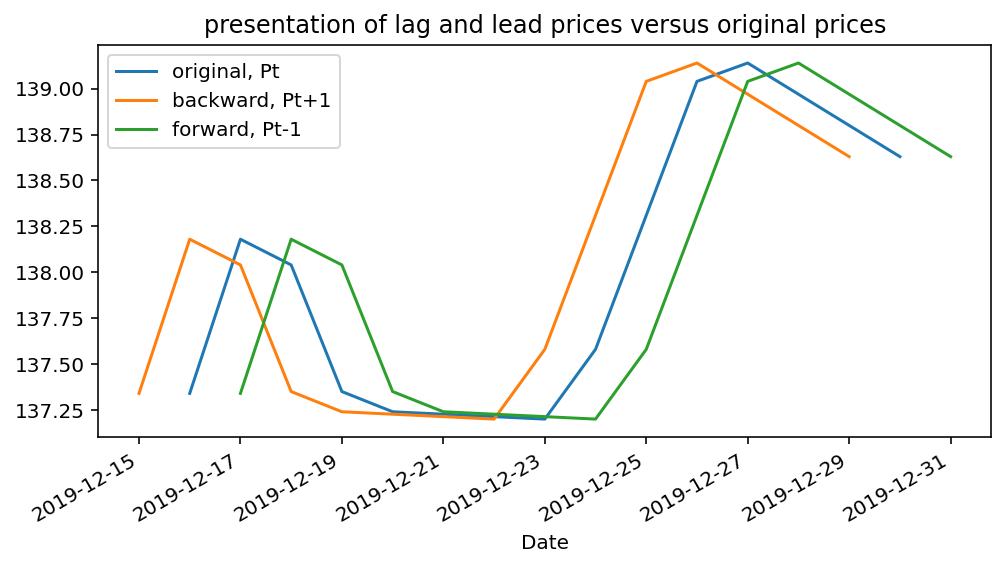

In [99]:
# A shift forward in time is called a lag, and a shift backward in time is called a lead.
Pt.plot(figsize=(8, 3), label="original, Pt")
Pt.shift(-1, freq="D").plot(figsize=(8, 4), label="backward, Pt+1")
Pt.shift(1, freq="D").plot(figsize=(8, 4), label="forward, Pt-1")
plt.title("presentation of lag and lead prices versus original prices")
plt.legend()
plt.show()

#### Example: analyzing the first difference

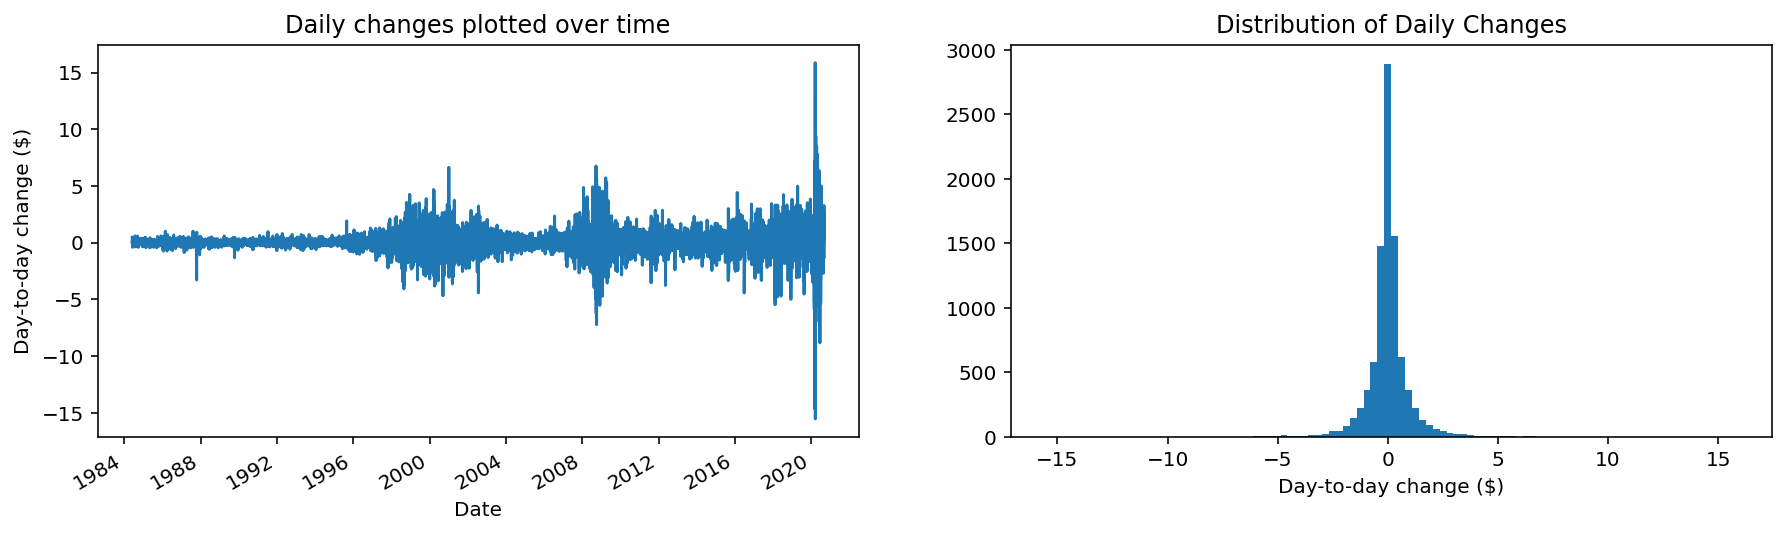

In [100]:
# Compute first difference
diff = prices - prices.shift(1)

# the subplot on the left
plt.subplot(121)
diff.plot(figsize=(15, 4))
plt.title("Daily changes plotted over time")
plt.ylabel("Day-to-day change ($)")

# the subplot on the right
plt.subplot(122)
diff.hist(figsize=(15, 4), bins=100, grid=False)
plt.title("Distribution of Daily Changes")
plt.xlabel("Day-to-day change ($)")

plt.show()

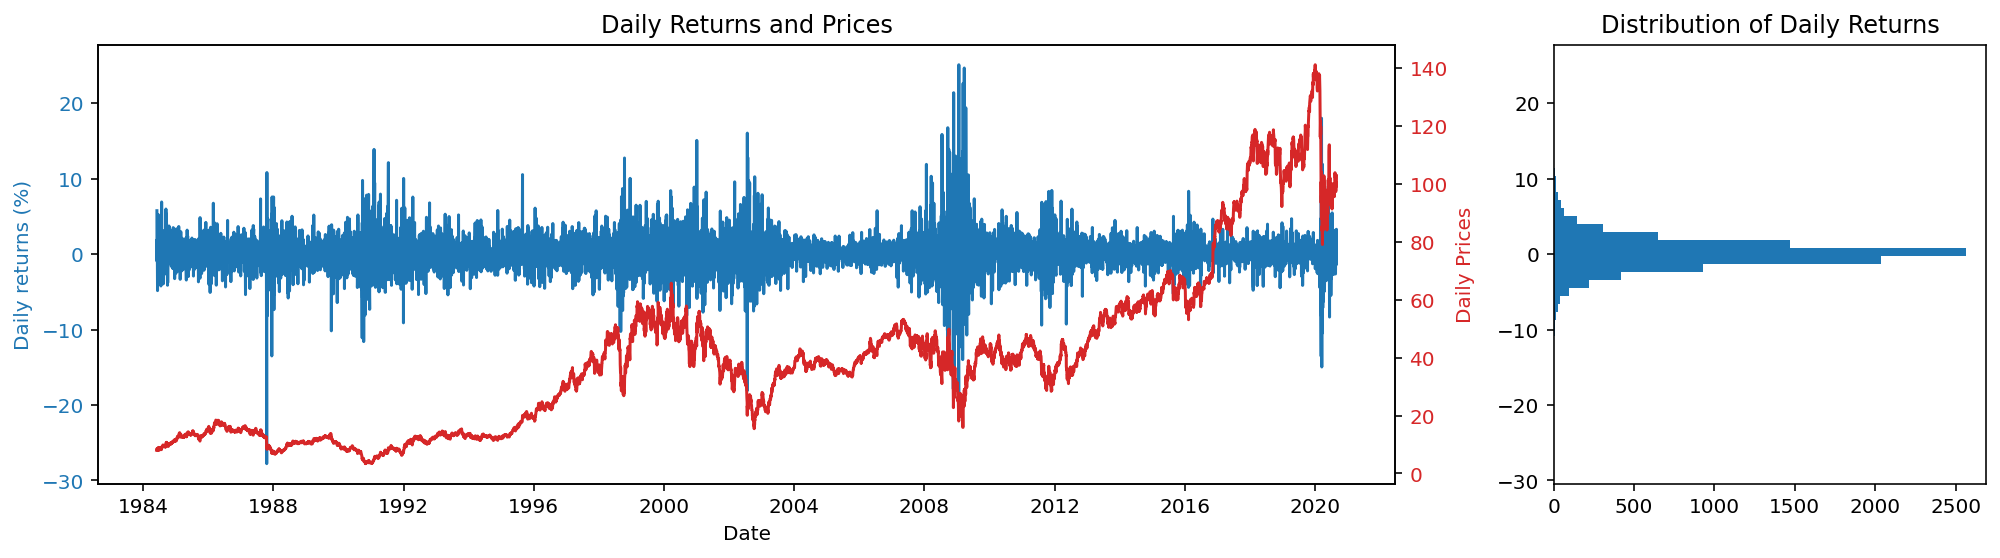

In [101]:
# Compute daily returns: divide the first difference by the price in the previous day
daily_percentage_change = 100 * diff / prices.shift(1)

# drop the first value which is NaN
daily_percentage_change.dropna(inplace=True)

# Plot the results and original prices together
# initialize two subplots in 1 row and two columns. Also specify the width of each plot
fig, ax1 = plt.subplots(1, 2, figsize=(14, 4), gridspec_kw={"width_ratios": [3, 1]})

# subplot for daily_percentage_change
color = "tab:blue"
ax1[0].set_xlabel("Date")
ax1[0].set_ylabel("Daily returns (%)", color=color)
ax1[0].plot(daily_percentage_change, color=color)
ax1[0].tick_params(axis="y", labelcolor=color)

# Create twin axes, so they can share the same xaxis, i.e. Dates
ax2 = ax1[0].twinx()

# daily prices on the same subplot
color = "tab:red"
ax2.set_ylabel("Daily Prices", color=color)
ax2.plot(prices, color=color)
ax2.tick_params(axis="y", labelcolor=color)

plt.title("Daily Returns and Prices")

# create the second subplot which is the histogram of daily_percentage_change
ax1[1].hist(daily_percentage_change, bins=50, orientation="horizontal")
ax1[1].set_title("Distribution of Daily Returns")

fig.tight_layout()
plt.show()

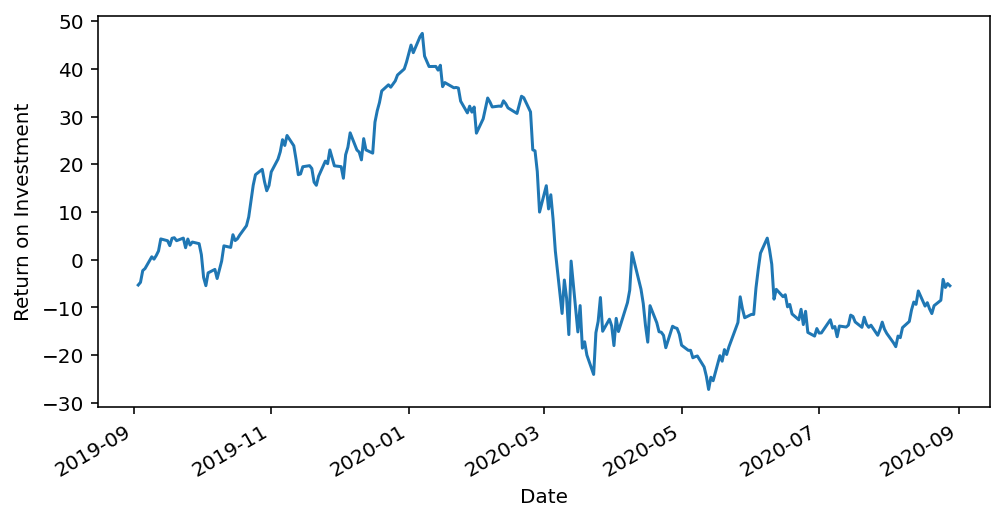

In [102]:
# Net profit over a year (in working days)
net_profit = prices - prices.shift(260)

# Return on Investment
roi = 100 * net_profit / prices.shift(260)

# Plot result
roi["2019-09-01":"2020-08-28"].plot(figsize=(8, 4))
plt.ylabel("Return on Investment")
plt.show()

In [ ]:
# if we specify the input parameter freq as in Pt.shift(1, freq='B') which means shifting forward by 1 business day, 
# the prices are aligned with the dates and thus will not be dropped.

#### Resampling and converting frequencies

In [ ]:
# resample(): data aggregation, first splits the data into buckets based on the new frequency and then 
# applies a particular operation to the data in each bucket
# asfreq(): data selection, starts with the first data point, then takes consecutive data points at 
# the new frequency interval

# Downsampling: decreased the frequency from day to year
# Upsampling: backward fill and forward fill

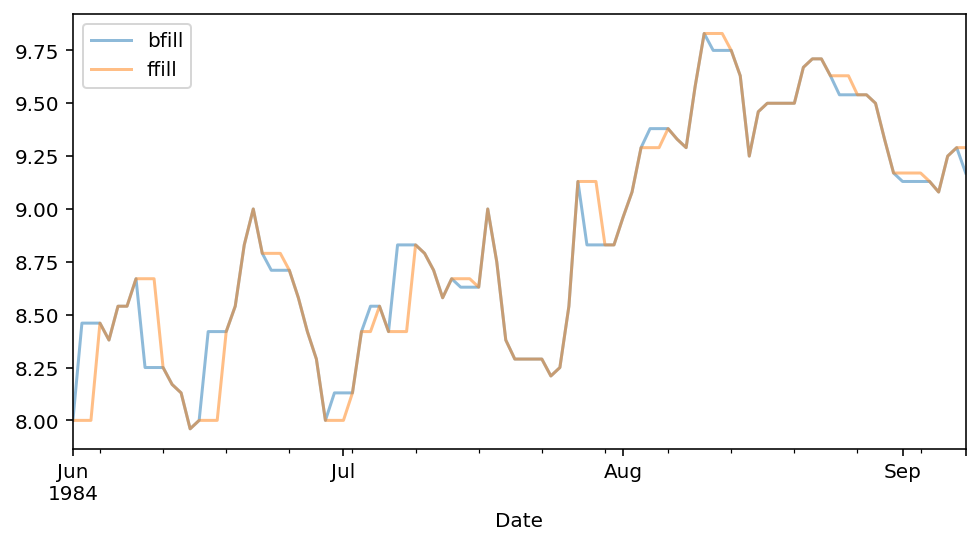

In [103]:
# Create the figure
plt.figure(figsize=(8, 4))

# Upsampling
# "backward fill" - fill missing with the closest value on the right
prices.asfreq("D", method="bfill")[0:100].plot(alpha=0.5)

# "forward fill" - fill missing with the closest value on the left
prices.asfreq("D", method="ffill")[0:100].plot(alpha=0.5)

plt.legend(["bfill", "ffill"], loc="upper left")
plt.show()

In [ ]:
# Skewness: degree of asymmetry around the center
# A skewness of smaller or larger than 0 indicates some degree of asymmetry
# Kurtosis: how the tails are stretched on both sides of the distribution
# A kurtosis larger than 3:  the tails of the distrib are fat compared to the normal distribution

#### Rolling windows

In [ ]:
def detect_outliers_rolling(timeseries, days=10, n_std=2, center=False):

    rolling_mean = timeseries.rolling(window=days, center=center).mean()
    rolling_std = timeseries.rolling(window=days, center=center).std()
    lower_bound = rolling_mean - (n_std * rolling_std)
    upper_bound = rolling_mean + (n_std * rolling_std)

    # Identify outliers
    mask = (timeseries < lower_bound) | (timeseries > upper_bound)
    outliers = timeseries[mask]

    # Plot bounds and outliers
    plt.figure(figsize=(12, 6))
    plt.plot(timeseries, "lightblue", label="Time series")
    plt.plot(rolling_mean, "orange", label="Rolling mean")
    plt.plot(upper_bound, "r--", label="Bounds", alpha=0.5)
    plt.plot(lower_bound, "r--", label="", alpha=0.5)
    plt.plot(outliers, "ro", markersize=5, label="Outlier candidate")
    plt.legend(loc="best")
    plt.grid(True)
    plt.title(
        "{} outliers detected using a moving window of size = {}".format(
            len(outliers), days
        )
    )
    plt.show()

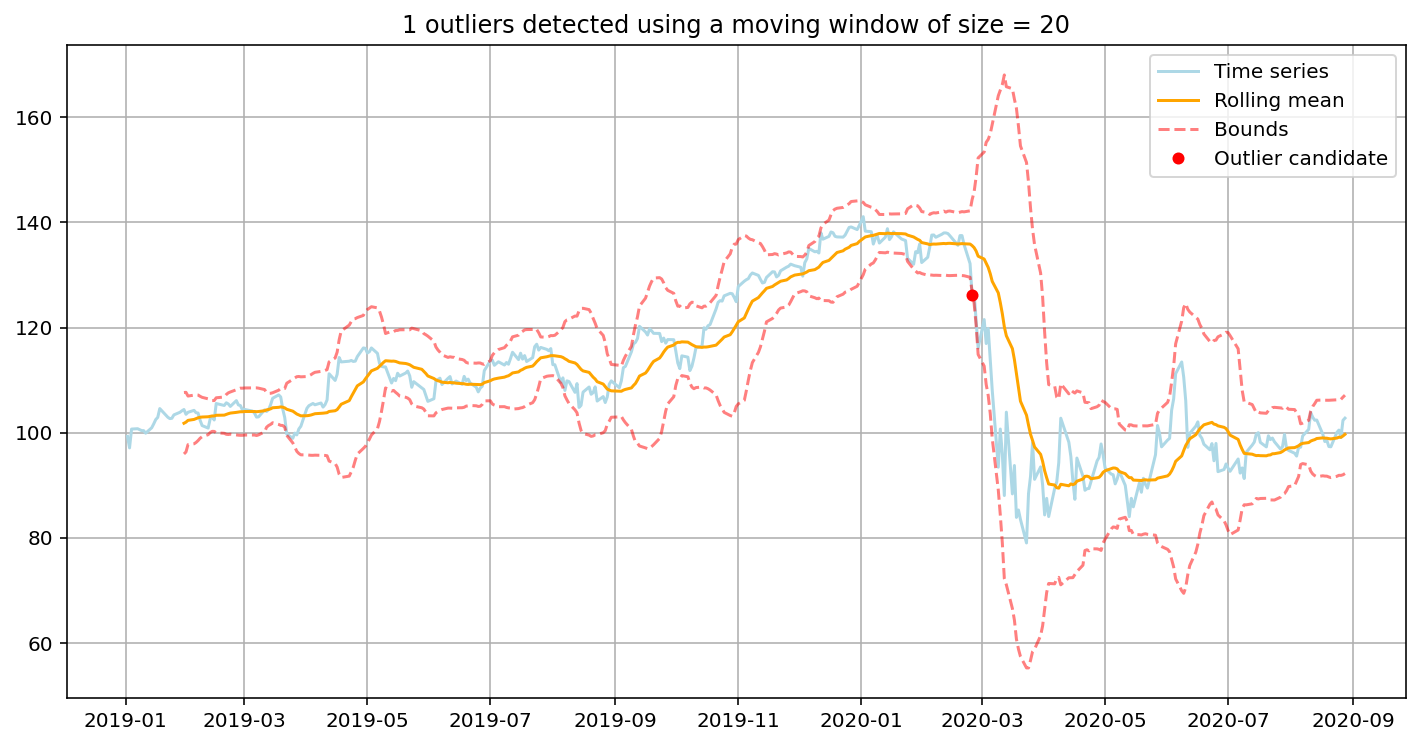

In [105]:
detect_outliers_rolling(prices["2019":"2022"], days=20, n_std=3)

#### Exercise: temperature and weather data
Task 2: Szeged Weather Data

Your task is to obtain the mean hourly temperatures and the mean monthly temperatures over all dates from 2006 to 2009. Your final two plots should look like this

In [164]:
data = pd.read_csv("resources 21/c2_weatherHistory.csv", index_col="Date", parse_dates=True)

In [137]:
data.head()

,Summary,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km)
Date,,,,,,
2006-04-01 00:00:00,Partly Cloudy,9.472222,0.89,14.1197,251,15.8263
2006-04-01 01:00:00,Partly Cloudy,9.355556,0.86,14.2646,259,15.8263
2006-04-01 02:00:00,Mostly Cloudy,9.377778,0.89,3.9284,204,14.9569
2006-04-01 03:00:00,Partly Cloudy,8.288889,0.83,14.1036,269,15.8263
2006-04-01 04:00:00,Mostly Cloudy,8.755556,0.83,11.0446,259,15.8263


In [138]:
print(data.index)

DatetimeIndex(['2006-04-01 00:00:00', '2006-04-01 01:00:00',
               '2006-04-01 02:00:00', '2006-04-01 03:00:00',
               '2006-04-01 04:00:00', '2006-04-01 05:00:00',
               '2006-04-01 06:00:00', '2006-04-01 07:00:00',
               '2006-04-01 08:00:00', '2006-04-01 09:00:00',
               ...
               '2013-07-27 17:00:00', '2013-07-27 18:00:00',
               '2013-07-27 19:00:00', '2013-07-27 20:00:00',
               '2013-07-27 21:00:00', '2013-07-27 22:00:00',
               '2013-07-27 23:00:00', '2013-07-28 00:00:00',
               '2013-07-28 01:00:00', '2013-07-28 02:00:00'],
              dtype='datetime64[ns]', name='Date', length=65499, freq=None)


In [139]:
print(min(data.index))
print(max(data.index))

2006-01-01 00:00:00
2013-12-31 23:00:00


In [154]:
data['hour'] = data.index.hour
data['month'] = data.index.month

In [143]:
data.year.max()

2013

In [147]:
data["2006":"2009"].groupby(['hour']).mean()['Temperature (C)']

hour
0      9.454293
1      9.030033
2      8.747593
3      8.289330
4      8.020971
5      7.816473
6      7.864769
7      8.799072
8     10.317918
9     12.016556
10    13.504415
11    14.663126
12    15.556297
13    16.123857
14    16.422534
15    16.469633
16    16.110430
17    15.488239
18    14.579949
19    13.474241
20    12.181025
21    11.069800
22    10.624610
23    10.060735
Name: Temperature (C), dtype: float64

In [ ]:
data = data["2006":"2009"]

In [177]:
hour_mean = data.groupby(data.index.time).mean()['Temperature (C)']
month_mean = data.groupby(data.index.month).mean()['Temperature (C)']

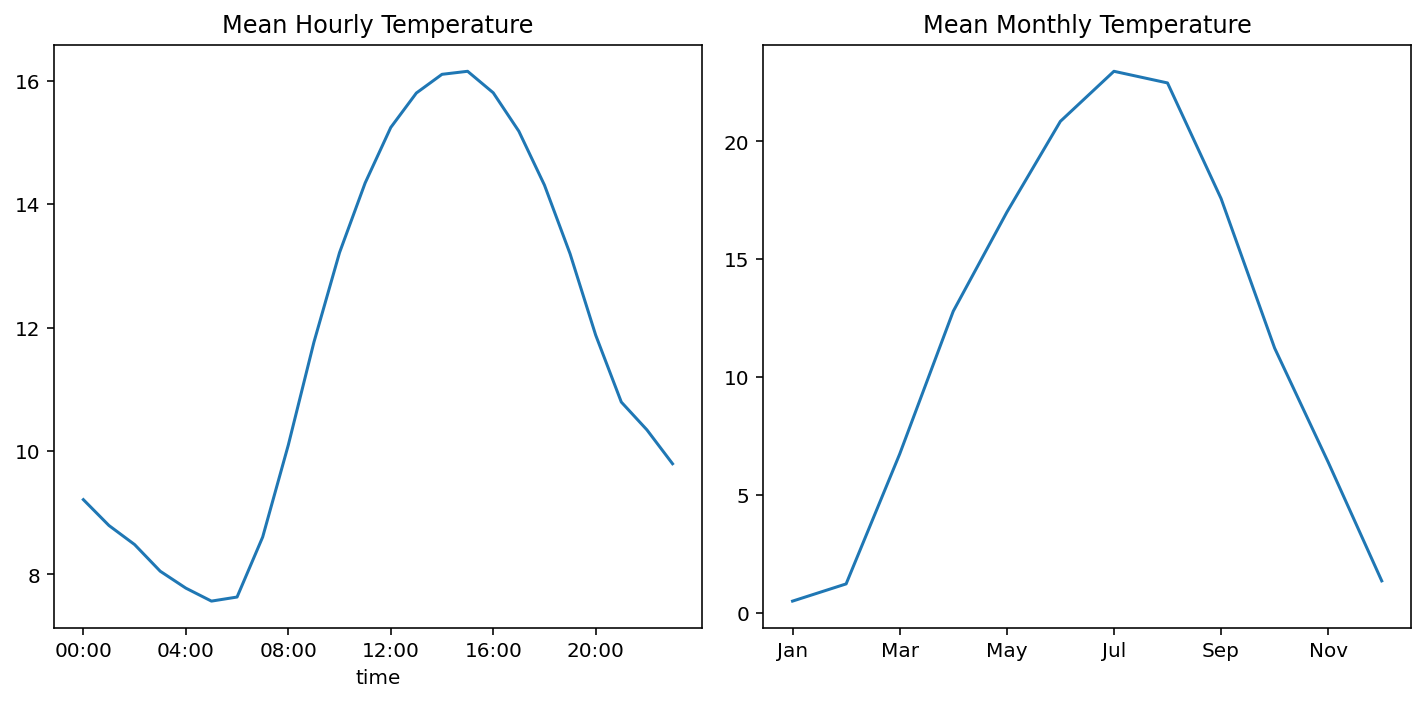

In [182]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (10, 5))

hourly_ticks = 4 * 60 * 60 * np.arange(6)

month_mean.index = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec",]
monthly_ticks = 2 * np.arange(6)

hour_mean.plot(ax=ax[0], title='Mean Hourly Temperature', xticks=hourly_ticks)
month_mean.plot(ax=ax[1], title='Mean Monthly Temperature', xticks=monthly_ticks)


fig.tight_layout()

#### Trends and cycles
Trend: upward or downward, changes its direction over time

Cyclical variations: recurring patterns over time

"by taking the average of the monthly values in each decade, we can smooth out all the seasonalities and reveal an upward and long-term trend in temperature over the whole period"

Cycles with a fixed frequency are referred to as seasonalities because they are associated with some aspect of the calendar and happen at a fixed frequency (e.g. weather temperature). On the other hand, some phenomena show cyclical patterns with varying frequencies (e.g. business cycles).

#### Temporal dependencies in time series data
Some time series data carry information from one period to the next. For instance, the total sales of a supermarket at the end of a day is not very different from the total sales at the end of the previous day.

The strength of this dependency from one period to the next does not remain the same across all periods. Moreover, the strength of this dependency can change if we don’t take two consecutive periods.

Autocorrelation or Serial correlation: autocorrelation measures the correlation across time periods within a single variable.

Instead of using the scatter plot to plot the time series data against its lagged values, we can use the lag_plot from Pandas. from pandas.plotting import lag_plot

#### Stationary and non-stationary data
In time series analysis, the data is non-stationary if it shows different behavior over time.

If the **level** (mean) and **variance** of the variable change over time, then it is not stationary

#### Decomposition of data into trends and cycles
* level, trend, cycle --> deterministic components
    * The level refers to the value around which the data may fluctuate
    * The trend refers to the upward or downward patterns in the data
    * The cycle refers to the recurring patterns over time
    
* random part
    * not predictable

In [184]:
from statsmodels.tsa.deterministic import DeterministicProcess

#  create the time index
index = pd.period_range("2021-01-01", freq="M", periods=12)

# create the deterministic components
det_components = DeterministicProcess(
    index, constant=True, order=1, seasonal=True, period=3, fourier=0
)
det_components.in_sample()

,const,trend,"s(2,3)","s(3,3)"
2021-01,1.0,1.0,0.0,0.0
2021-02,1.0,2.0,1.0,0.0
2021-03,1.0,3.0,0.0,1.0
2021-04,1.0,4.0,0.0,0.0
2021-05,1.0,5.0,1.0,0.0
2021-06,1.0,6.0,0.0,1.0
2021-07,1.0,7.0,0.0,0.0
2021-08,1.0,8.0,1.0,0.0
2021-09,1.0,9.0,0.0,1.0
2021-10,1.0,10.0,0.0,0.0


#### Stationarity
* The Augmented Dickey-Fuller (ADF) test. The null hypothesis is that the data has a unit root (i.e. the data is non-stationary), and if we fail to reject the null hypothesis, this test may provide evidence that the series is non-stationary.
* The null hypothesis for the KPSS test, in contrast to the ADF test, is that the data is stationary around a deterministic trend, i.e. trend-stationary
* In statistical hypothesis testing, we reject the null hypothesis if the p-value is less than significance level of 0.05.

* Case 1: Both tests conclude that the series is not stationary. Then the series is not stationary
* Case 2: Both tests conclude that the series is stationary. Then the series is stationary
* Case 3: KPSS indicates stationarity and ADF indicates non-stationarity. Then the series is trend stationary and should be detrended to become stationary.
* Case 4: KPSS indicates non-stationarity and ADF indicates stationarity. Then the series is difference stationary and should be differenced to become stationary.

## Databases in Python

In [41]:
import sqlite3

db = sqlite3.connect("c2_database.sqlite")

In [42]:
def run_query(query):
    return pd.read_sql_query(query, db)

1) What was the duration of the longest trip?

In [43]:
query = '''SELECT tbl_name FROM sqlite_master'''
run_query(query)

,tbl_name
0,station
1,status
2,trip
3,weather


In [44]:
query = '''SELECT duration FROM trip ORDER BY duration DESC LIMIT 1'''
run_query(query)

,duration
0,722236


2) How many trips were ended at the station ‘2nd at South Park ‘?

In [26]:
query = '''SELECT count(*) 
FROM trip 
WHERE end_station_name = "2nd at South Park"'''
run_query(query)

,count(*)
0,2150


3) How many trips had a duration between 1000 and 2000?

In [27]:
query = '''SELECT count(*) 
FROM trip 
WHERE duration BETWEEN 1000 AND 2000'''
run_query(query)

,count(*)
0,7225


4) Which bike was used for the most trips?

In [31]:
query = '''SELECT bike_id, count(*) 
FROM trip 
GROUP BY bike_id
ORDER BY count(*) DESC
LIMIT 1'''
run_query(query)

,bike_id,count(*)
0,392,277


5) Which are the top five stations for the number of round trips? (round trips start and end at the same station)

In [36]:
query = '''SELECT start_station_name,
                    SUM(start_station_id = end_station_id) AS round_trip
FROM trip
GROUP BY start_station_name
ORDER BY round_trip DESC
LIMIT 5'''
run_query(query)

,start_station_name,round_trip
0,Embarcadero at Sansome,255
1,Harry Bridges Plaza (Ferry Building),216
2,University and Emerson,117
3,Market at 4th,92
4,2nd at Townsend,82


#### Creating and modifying databases

In [45]:
db = sqlite3.connect("my_database.db")

In [46]:
# creating a table
query = '''CREATE TABLE customer (id INTEGER PRIMARY KEY, first_name TEXT, last_name TEXT, age INTEGER)'''

cursor = db.cursor()
cursor.execute(query)

In [48]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
results = cursor.fetchall()
print(results)

[('customer',)]


In [49]:
# adding a row
query = "INSERT INTO customer VALUES  (701, 'Mackenzie', 'Fox', 35)"
cursor.execute(query)
db.commit()

In [50]:
cursor.execute("SELECT * FROM customer;")
results = cursor.fetchall()
print(results)

[(701, 'Mackenzie', 'Fox', 35)]


In [51]:
# adding a column
cursor.execute("ALTER TABLE customer ADD COLUMN city TEXT DEFAULT 'Geneva';")
db.commit()

In [52]:
cursor.execute("SELECT * FROM customer;")
results = cursor.fetchall()
print(results)

[(701, 'Mackenzie', 'Fox', 35, 'Geneva')]


In [53]:
# adding rows from a pandas df
df2 = pd.DataFrame(
    [[702, "Emily", "Joy", 49, "Geneva"]],
    columns=["id", "first_name", "last_name", "age", "city"],
)

df2.to_sql(name="customer", con=db, if_exists="append", index=False)

In [54]:
cursor.execute("SELECT * FROM customer;")
results = cursor.fetchall()
print(results)

[(701, 'Mackenzie', 'Fox', 35, 'Geneva'), (702, 'Emily', 'Joy', 49, 'Geneva')]


In [55]:
# updating rows
update = '''
UPDATE customer
SET city="Zurich"
WHERE id=702;
'''
cursor.execute(update)
db.commit()

In [56]:
cursor.execute("SELECT * FROM customer;")
results = cursor.fetchall()
print(results)

[(701, 'Mackenzie', 'Fox', 35, 'Geneva'), (702, 'Emily', 'Joy', 49, 'Zurich')]


In [57]:
# deleting rows
delete = '''
DELETE FROM customer
WHERE id=702;
'''
cursor.execute(delete)
db.commit()

In [58]:
cursor.execute("SELECT * FROM customer;")
results = cursor.fetchall()
print(results)

[(701, 'Mackenzie', 'Fox', 35, 'Geneva')]


In [59]:
# db from csv file
db = sqlite3.connect("songs.db")
cursor = db.cursor()

In [60]:
for chunk in pd.read_csv("c2_songs.csv", chunksize=4):
    chunk.to_sql(name="data", con=db, if_exists="append", index=False)
    print(chunk.iloc[0, 2])

Stairway to Heaven
Black Dog
All My Love
Rebel Rebel
Golden Years


In [62]:
pd.read_sql_query("SELECT * FROM data;", db)

,Musician,Genre,Name,Decade,Minutes
0,Led Zeppelin,hard rock,Stairway to Heaven,70,08:02
1,Led Zeppelin,hard rock,Kashmir,70,08:37
2,Led Zeppelin,hard rock,Immigrant Song,70,02:26
3,Led Zeppelin,hard rock,Whole Lotta Love,60,05:33
4,Led Zeppelin,hard rock,Black Dog,70,04:55
5,Led Zeppelin,hard rock,Good Times Bad Times,60,02:43
6,Led Zeppelin,hard rock,Moby Dick,60,04:25
7,Led Zeppelin,hard rock,Ramble On,60,04:35
8,Led Zeppelin,hard rock,All My Love,70,05:53
9,Led Zeppelin,hard rock,The Song Remains the Same,70,05:24


#### Exercise: the Consumer Finance Complaints data

**Task 1** 
In the first part of this exercise, you will transfer the data from the csv file to a database. Count the number of records for each table to ensure that you loaded all the data. You should have 65499 records.

In [63]:
# db from csv file
db = sqlite3.connect("complaints.db")
cursor = db.cursor()

In [ ]:
for chunk in pd.read_csv("c2_consumer_complaints.csv", chunksize=4):
    chunk.to_sql(name="data", con=db, if_exists="append", index=False)
    print(chunk.iloc[0, 2])

In [65]:
pd.read_sql_query("SELECT COUNT(*) FROM data;", db)

,COUNT(*)
0,65499


**Task 2**
Run an SQL query to return a DataFrame containing a unique list of submission methods for the complaints together with the number of complaints submitted via each method.

In [67]:
pd.read_sql_query("SELECT * FROM data LIMIT 5;", db)

,complaint_id,product,issue,company,state,zipcode,submitted_via,date_sent_to_company,date_received,company_response_to_consumer,timely_response,consumer_disputed?
0,511074,Mortgage,"Loan modification,collection,foreclosure",U.S. Bancorp,CA,95993,Referral,09/03/2013,08/30/2013,Closed with explanation,Yes,Yes
1,511080,Mortgage,"Loan servicing, payments, escrow account",Wells Fargo & Company,CA,91104,Referral,09/03/2013,08/30/2013,Closed with explanation,Yes,Yes
2,510473,Credit reporting,Incorrect information on credit report,Wells Fargo & Company,NY,11764,Postal mail,09/18/2013,08/30/2013,Closed with explanation,Yes,No
3,510326,Student loan,Repaying your loan,"Navient Solutions, Inc.",MD,21402,Email,08/30/2013,08/30/2013,Closed with explanation,Yes,Yes
4,511067,Debt collection,False statements or representation,Resurgent Capital Services L.P.,GA,30106,Web,08/30/2013,08/30/2013,Closed with explanation,Yes,Yes


In [77]:
pd.read_sql_query('''SELECT submitted_via Method,
                            COUNT(*) Number
                      FROM data
                      GROUP BY submitted_via
                      ORDER BY COUNT(*) DESC;''', db)

,Method,Number
0,Web,43947
1,Referral,10587
2,Phone,4974
3,Postal mail,4894
4,Fax,1076
5,Email,21


**Task 3** 
Build upon your SQL query from part 2 to return a third column in your DataFrame containing the total number of complaints (each row should contain the same number).

In [76]:
pd.read_sql_query('''SELECT submitted_via Method,
                            COUNT(*) Number,
                            (SELECT COUNT(*) FROM data) Total
                      FROM data
                      GROUP BY submitted_via
                      ORDER BY COUNT(*) DESC;''', db)

,Method,Number,Total
0,Web,43947,65499
1,Referral,10587,65499
2,Phone,4974,65499
3,Postal mail,4894,65499
4,Fax,1076,65499
5,Email,21,65499


**Task 4** Build upon your query from part 3 to add a column which gives the percentage of total complaints submitted via each of the methods.

In [82]:
pd.read_sql_query('''SELECT submitted_via Method,
                            COUNT(*) Number,
                            (SELECT COUNT(*) FROM data) Total,
                            (CAST (COUNT(*) AS double precision)/CAST ((SELECT COUNT(*) FROM data) AS double precision))*100 Percent
                      FROM data
                      GROUP BY submitted_via
                      ORDER BY COUNT(*) DESC;''', db)

,Method,Number,Total,Percent
0,Web,43947,65499,67.095681
1,Referral,10587,65499,16.163606
2,Phone,4974,65499,7.594009
3,Postal mail,4894,65499,7.471870
4,Fax,1076,65499,1.642773
5,Email,21,65499,0.032062


Concepts of center:
* mean: easily affected by outliers
* median: not affected by outliers

Measures of variation:
* range
* standard deviation (ex, s=28.789, it means that the data points are on average a distance of approx 29 away from the mean)
* standard error

Covariance and correlation:
* covariance: measure of how much two r.v change together; keeps the scale of the variables
* correlation: standardized measure of dependence; zero corr does not imply independence because it only captures linear relationship

Point estimates and CI:
* Point estimates, example: mu hat
* Confidence intervals: the confidence level is (approx.) the probability that our interval contains the parameter. If sigma is known, we use the z-score in the CI, otherwise we use the t-score. The higher the confidence the larger the interval has to be

Hypothesis testing:
* p-value: probability that the observed statistic occurred this way by chance. A very small p-value should give us confidence that what we are observing is not happening by chance. If the p-value is less than the significance value we reject the null hypothesis.
* Type I error: if we reject the null hypothesis when it is actually true (this is also called a false positive) - significant level
* Type II error: if we fail to reject the null hypothesis when it is actually false (this is known as a false negative)

AB testing:
* Chi-square: test for independence between two categorical variables

In [117]:
# np.corrcoef(X, Y)
# df["X"].corr(df["Y"])
# sns.heatmap(np.corrcoef(data))

# t-value: t = stats.t.ppf(q=0.975, df=9)

# stats.t.interval(alpha = 0.95,              # Confidence level
#                  df= 9,                     # Degrees of freedom
#                  loc = sample_small_mean,   # Sample mean
#                  scale = sigma)             # Standard deviation estimate

# t_statistic, p_value = stats.ttest_1samp(test_sample, popmean=population.mean())

# chi_square, p_value, df, matrix = stats.chi2_contingency(observed=results)

#### Exercise: hypothesis testing

In [87]:
import scipy.stats as stats
import random

In [88]:
poisson1 = stats.poisson.rvs(mu=55, size=200000)
poisson2 = stats.poisson.rvs(mu=10, size=100000)
population = np.concatenate((poisson1, poisson2))

data = pd.DataFrame(
    ["red"] * 50000 + ["blue"] * 30000 + ["green"] * 10000 + ["white"] * 10000
)

In [91]:
data.shape

(100000, 1)

In [108]:
sample_poisson = np.random.choice(population, size=1000)
sample_data = np.random.choice(data[0], size=1000)

In [109]:
t_statistic, p_value = stats.ttest_1samp(sample_poisson, popmean=population.mean())

In [110]:
print(t_statistic, p_value)

0.3834216502888634 0.7014887313677183


In [113]:
data_count = pd.crosstab(index=data[0], columns="count")
sample_count = pd.crosstab(index=sample_data, columns="count")
expected_count = data_count * len(sample_data) / len(data)
chi_square = (((sample_count - expected_count) ** 2) / expected_count).sum()
print(chi_square)

col_0
count    1.572
dtype: float64


In [115]:
p_value = 1 - stats.chi2.cdf(x=chi_square, df=3)
print(p_value)

[0.66575516]


In [118]:
chi_square, p_value, df, matrix = stats.chi2_contingency(observed=np.array([[5000, 3200], [5000, 3000]]))
print(chi_square, p_value)

3.9188195520259654 0.04774839665341007
